In [1]:
"""
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/my-files/projects/yem
"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n%cd /content/drive/MyDrive/my-files/projects/yem\n"

In [1]:
##############
## INITIATE ##
##############

## Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import yaml

## Import modules
from f_YEM_V1_14_2025_09_30 import pdf
from f_YEM_V1_14_2025_09_30 import f_normal
from f_YEM_V1_14_2025_09_30 import YellowstoneEcosystemModel
from f_YEM_V1_14_2025_09_30 import plot_model

## Set the device to MPS if available
device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
device = "cpu" # Force cpu for now
print(device)

## Figure parameters
plt.rcParams['figure.dpi'] = 300
figsize = (14,5)
custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'axes.facecolor':'whitesmoke'}
sns.set_theme(style="ticks", rc=custom_params)

#
###

cpu


In [21]:
####################
## INITIATE MODEL ##
####################

## Model
model = YellowstoneEcosystemModel("parameters-V1-14-2025-09-30.yaml")

#
###

0.68s


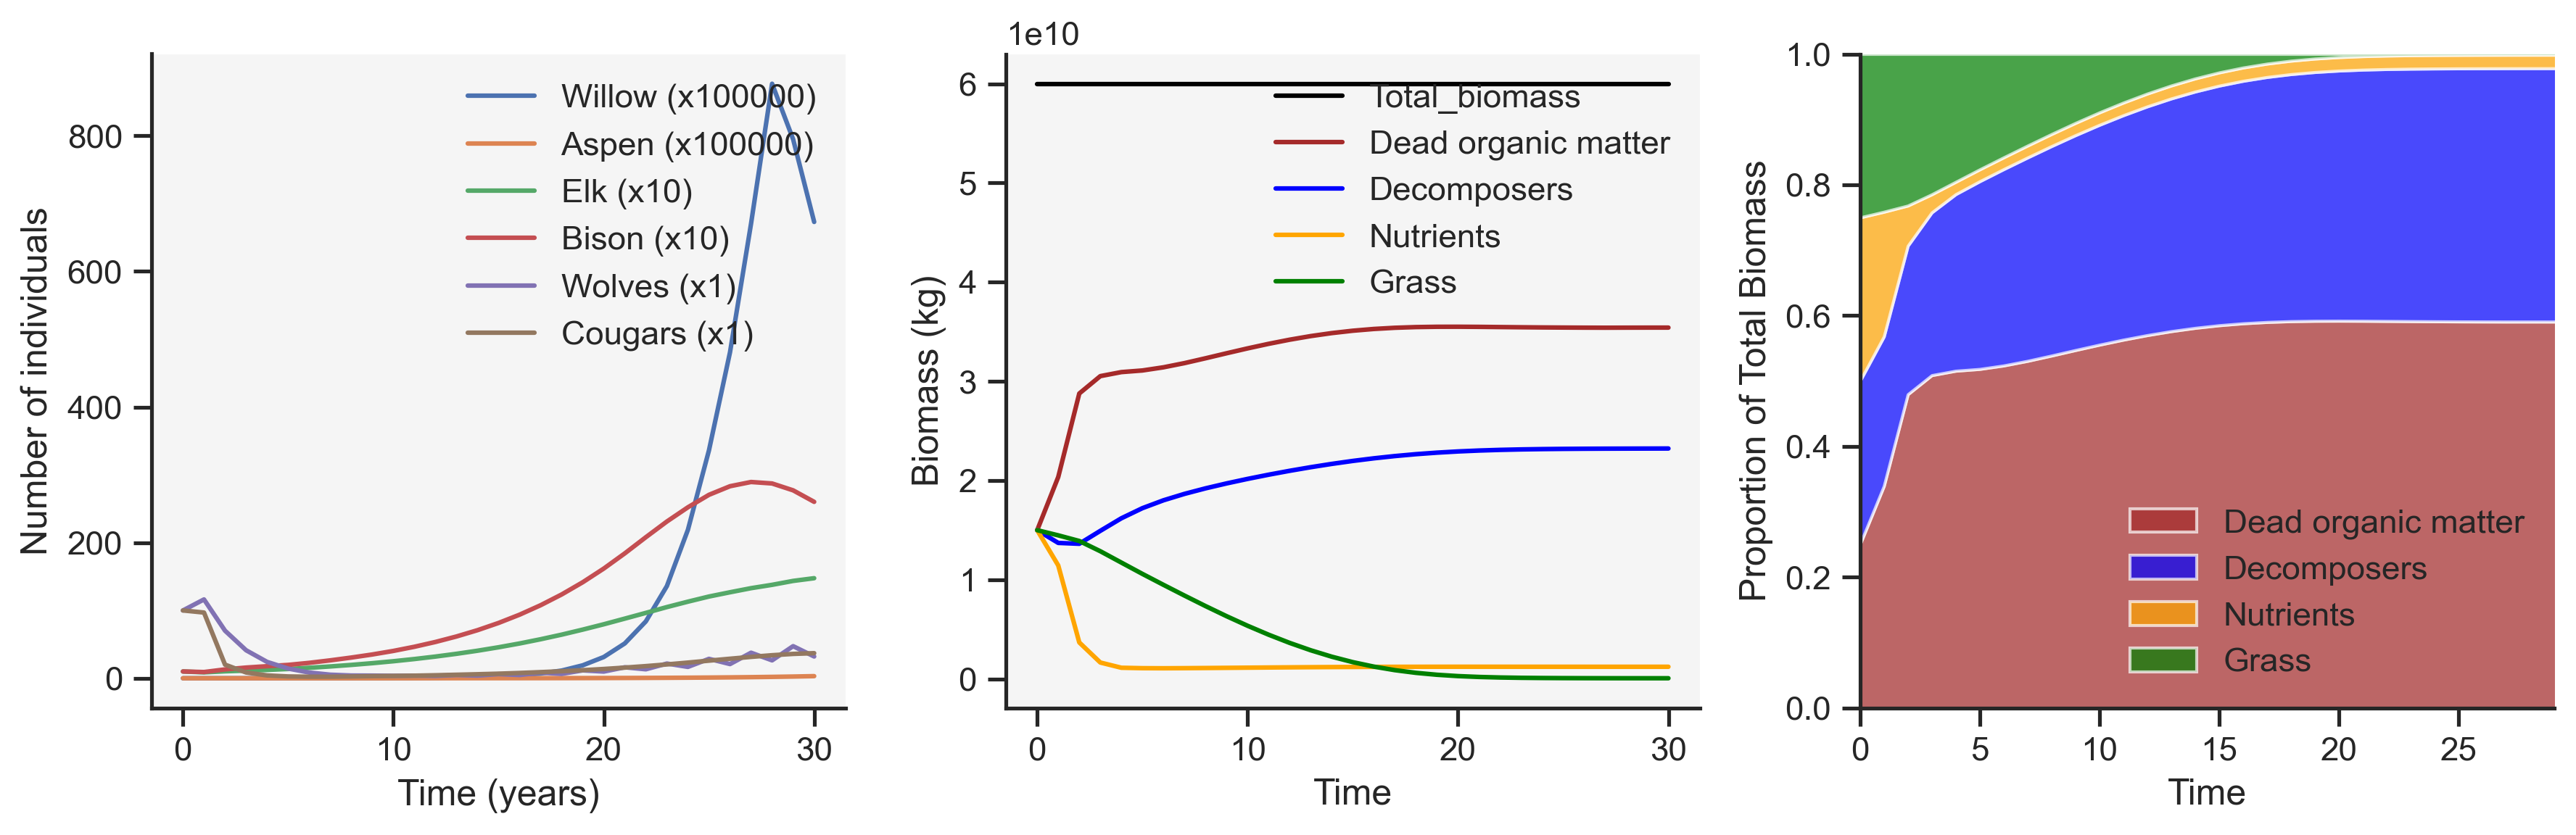

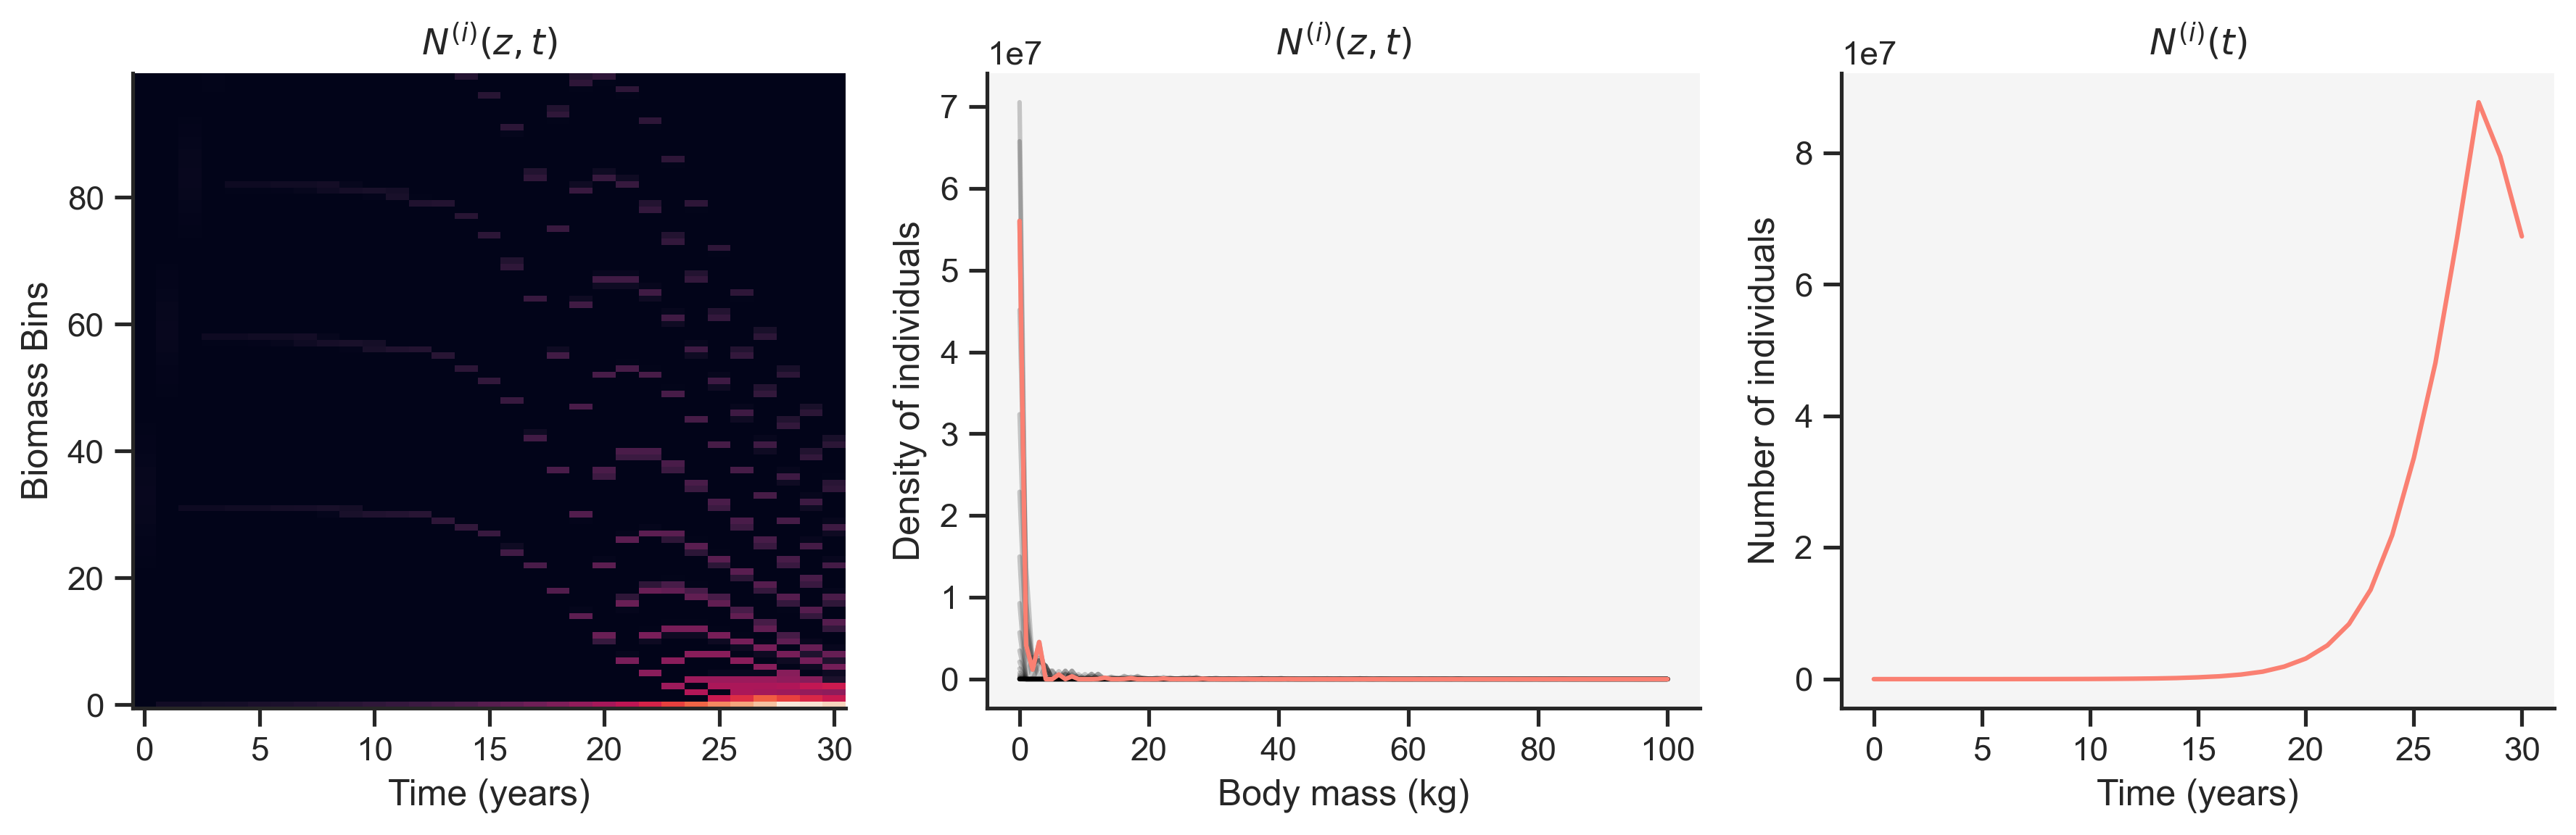

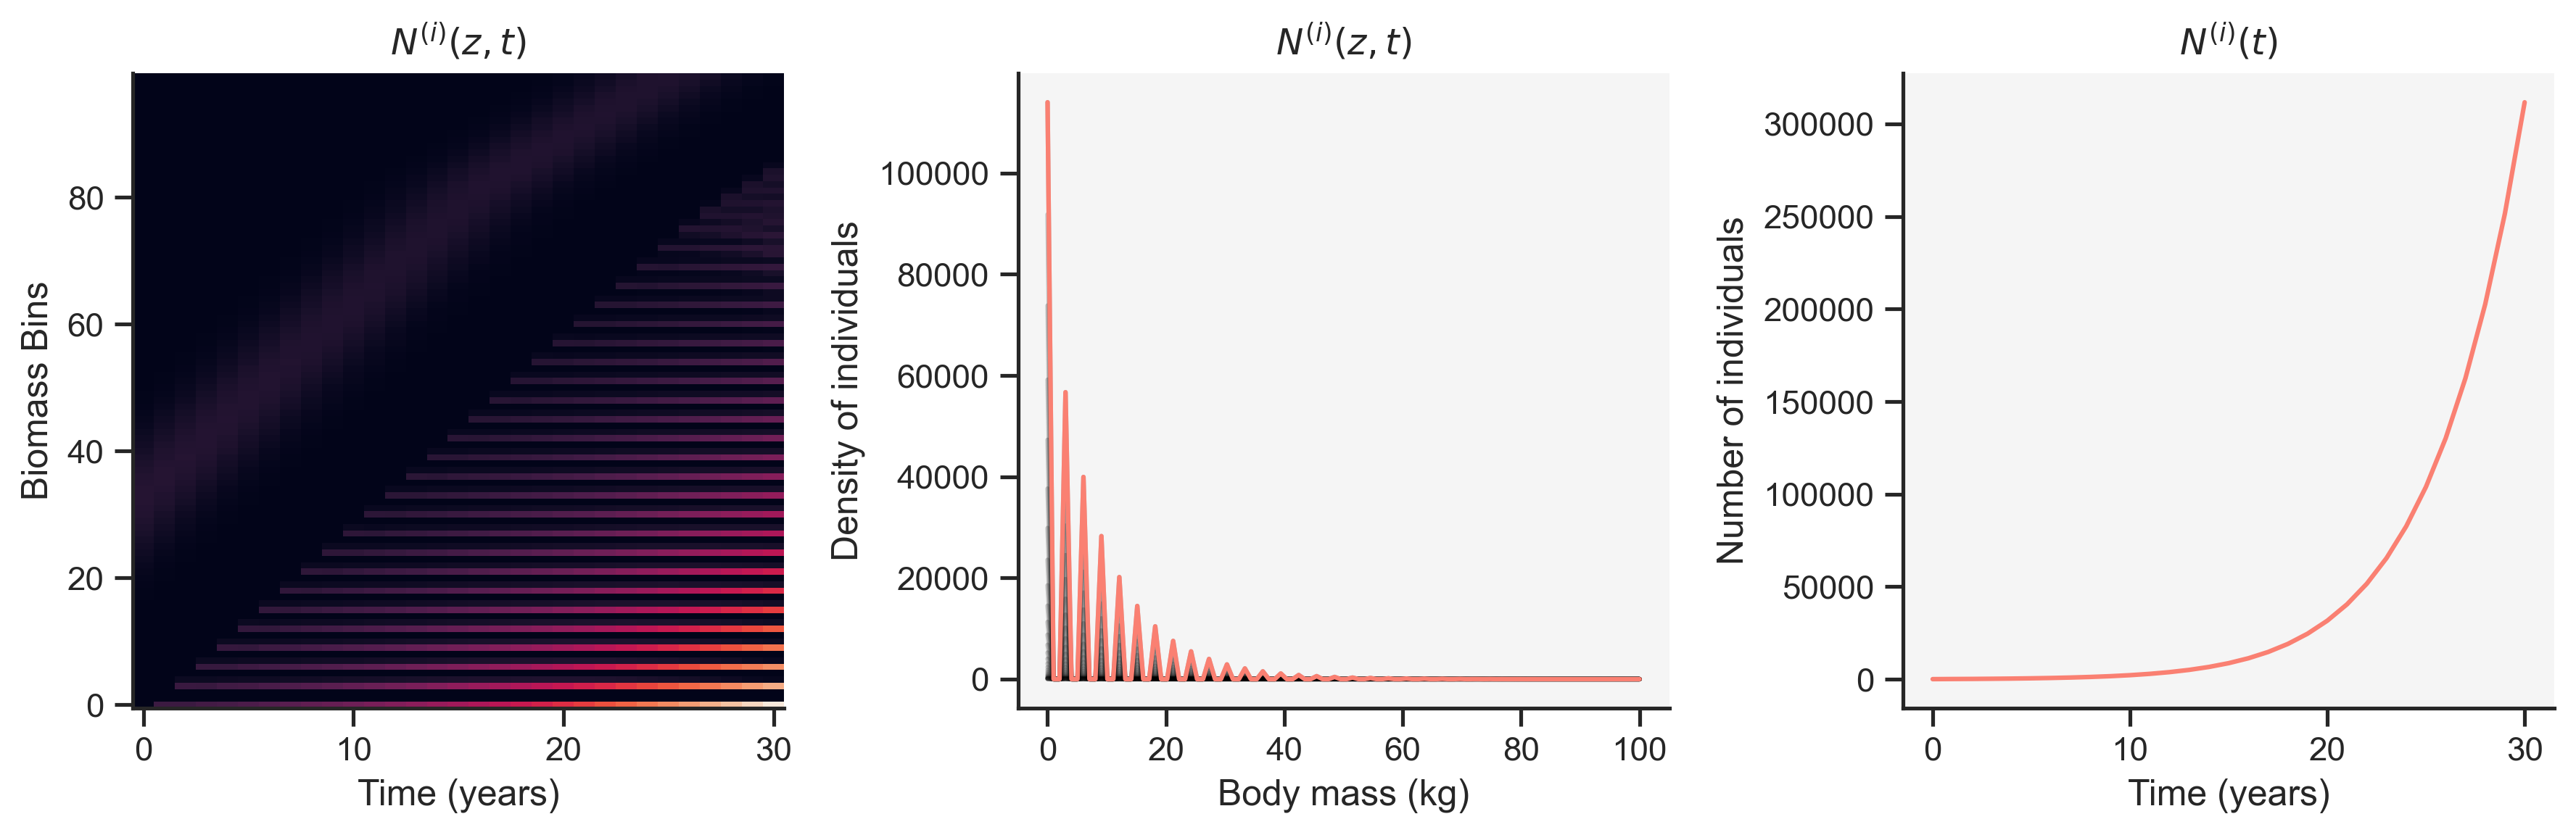

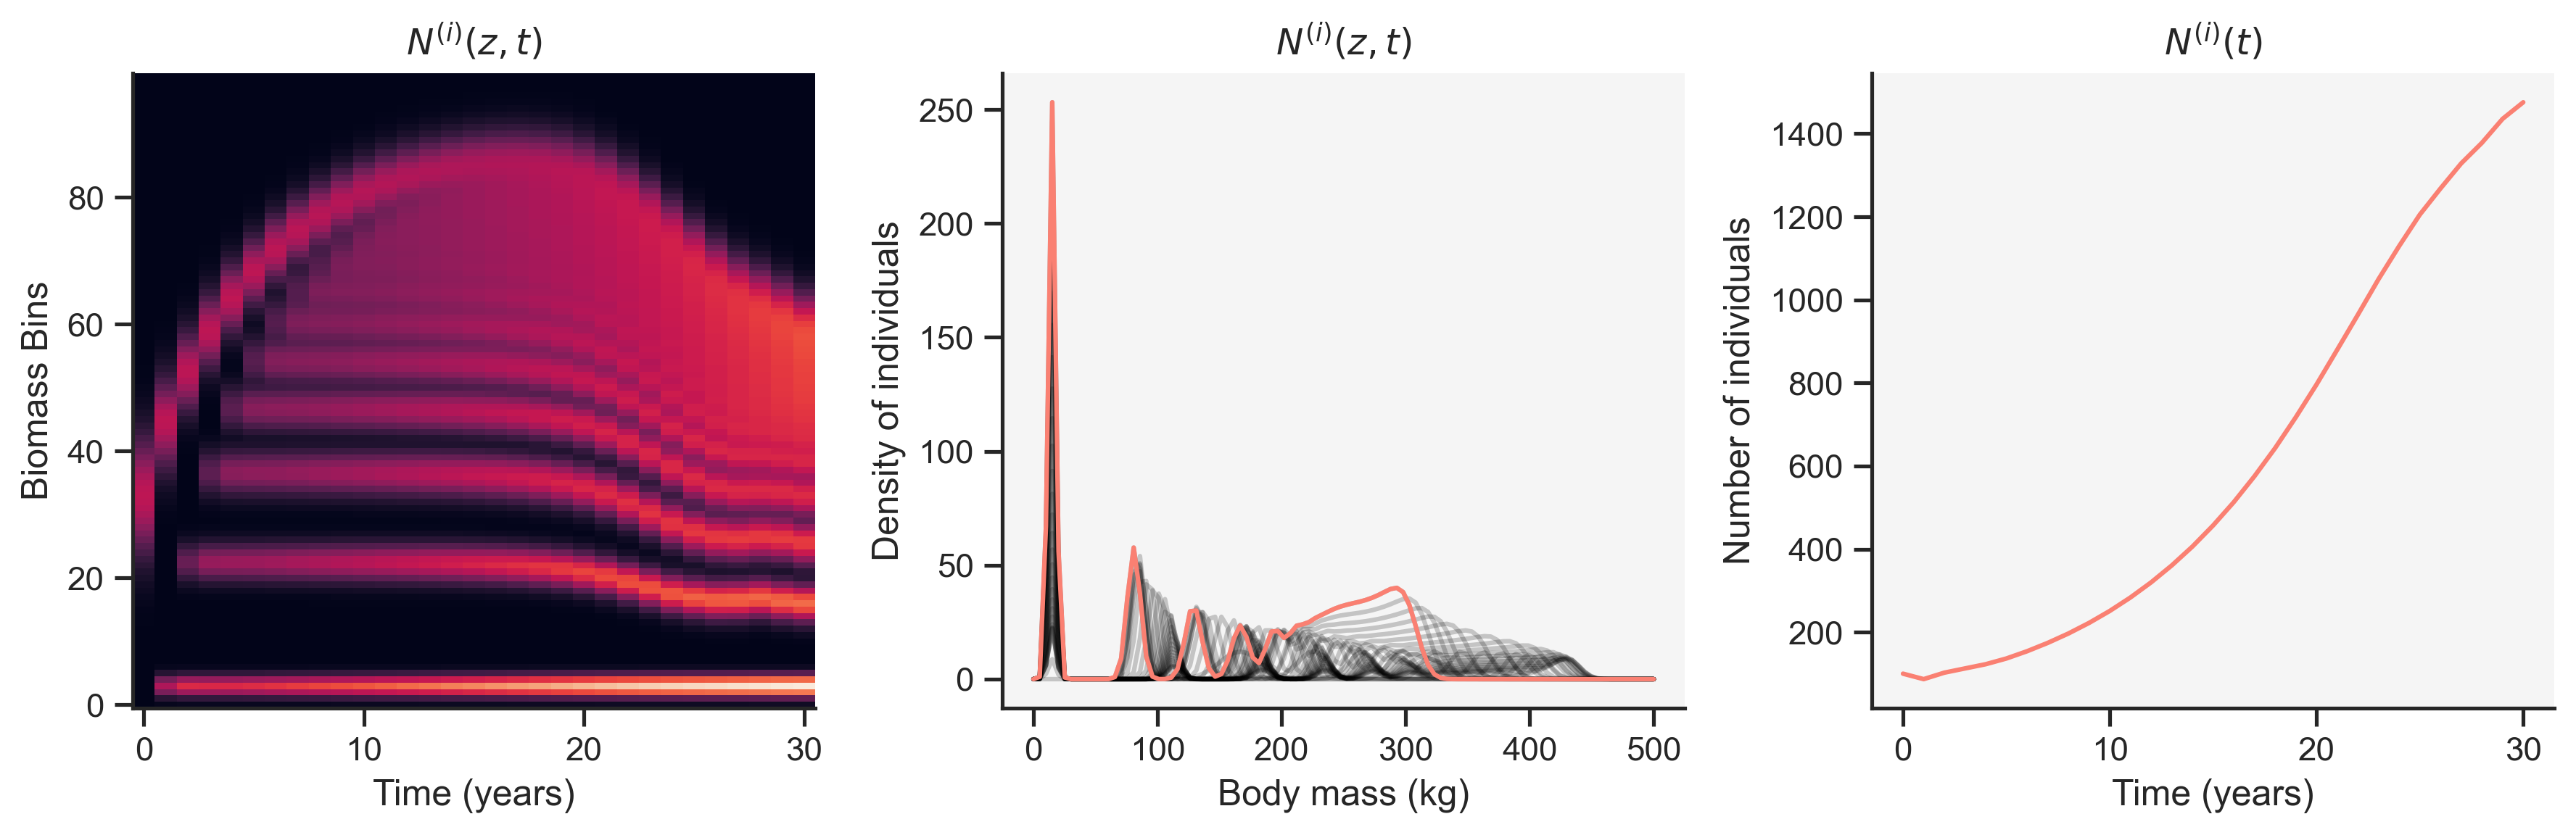

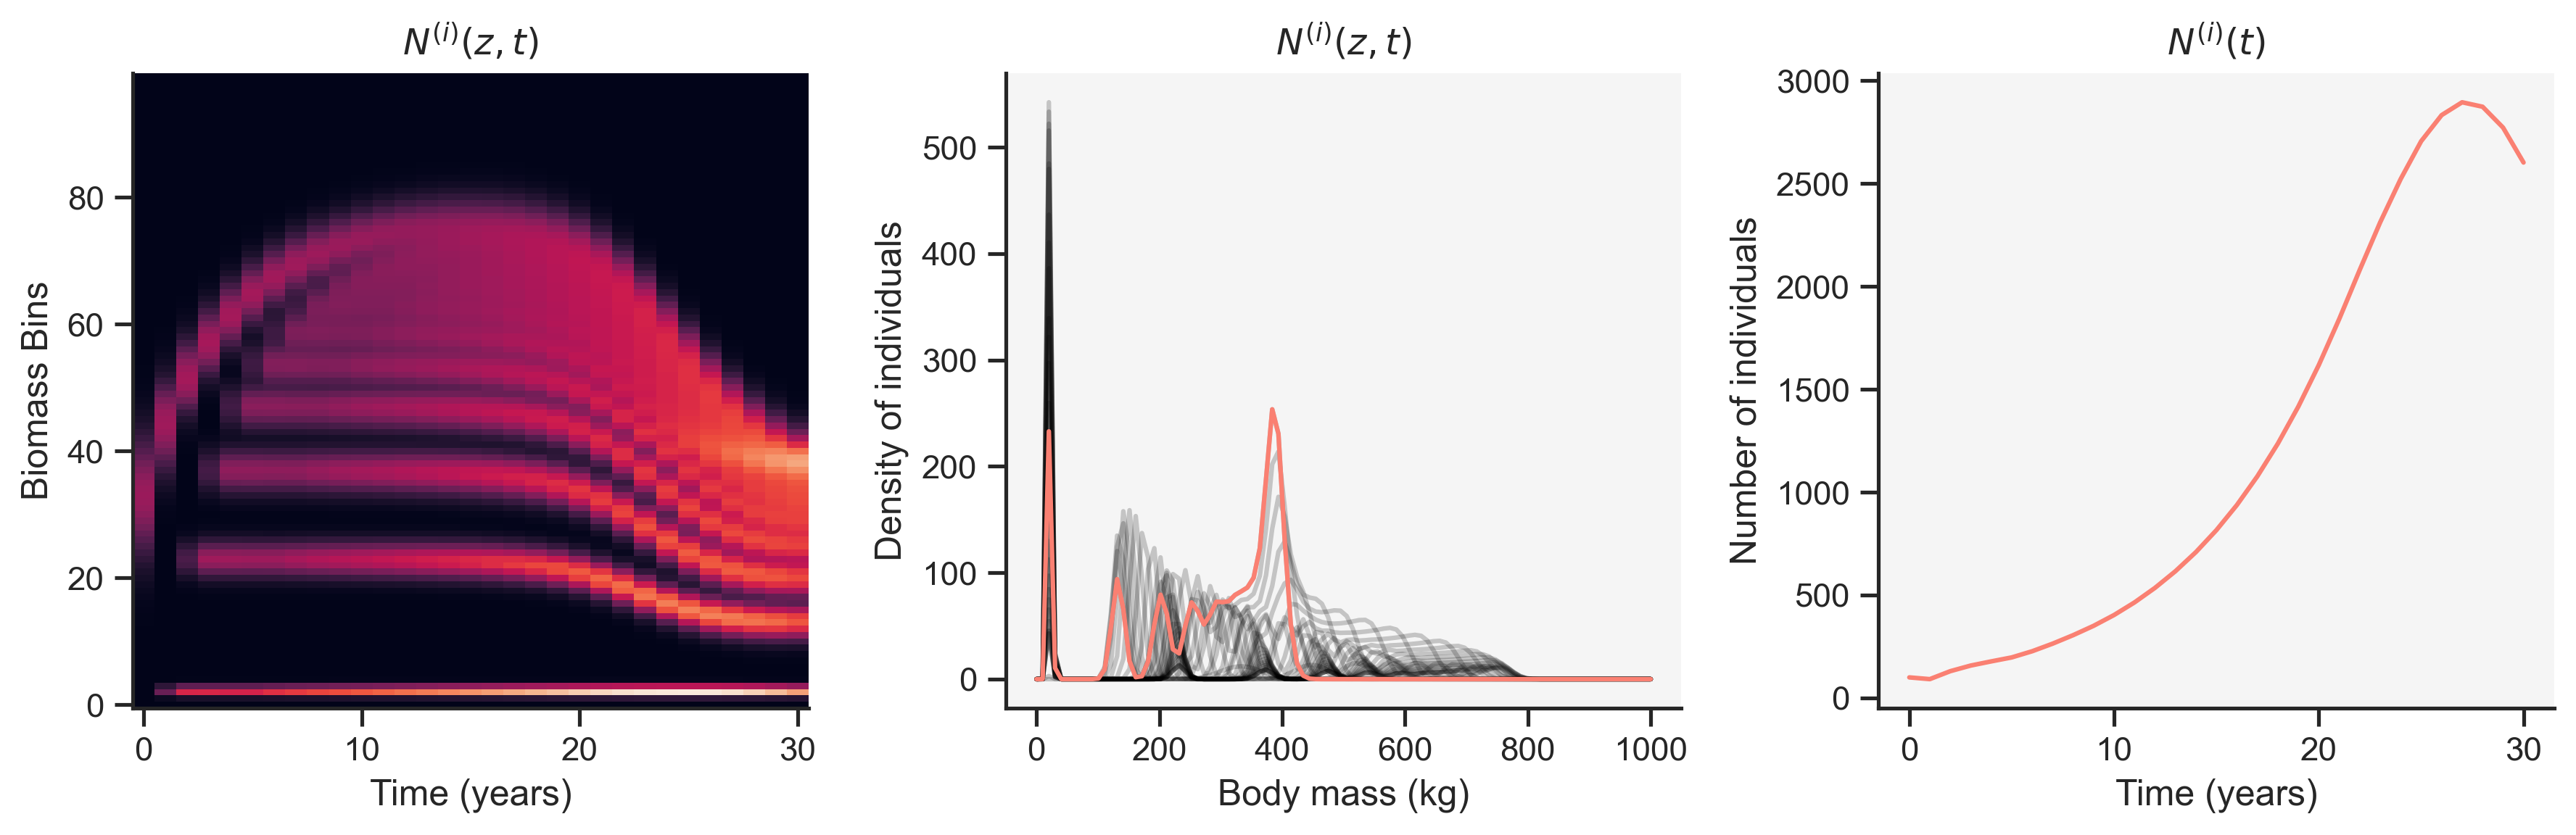

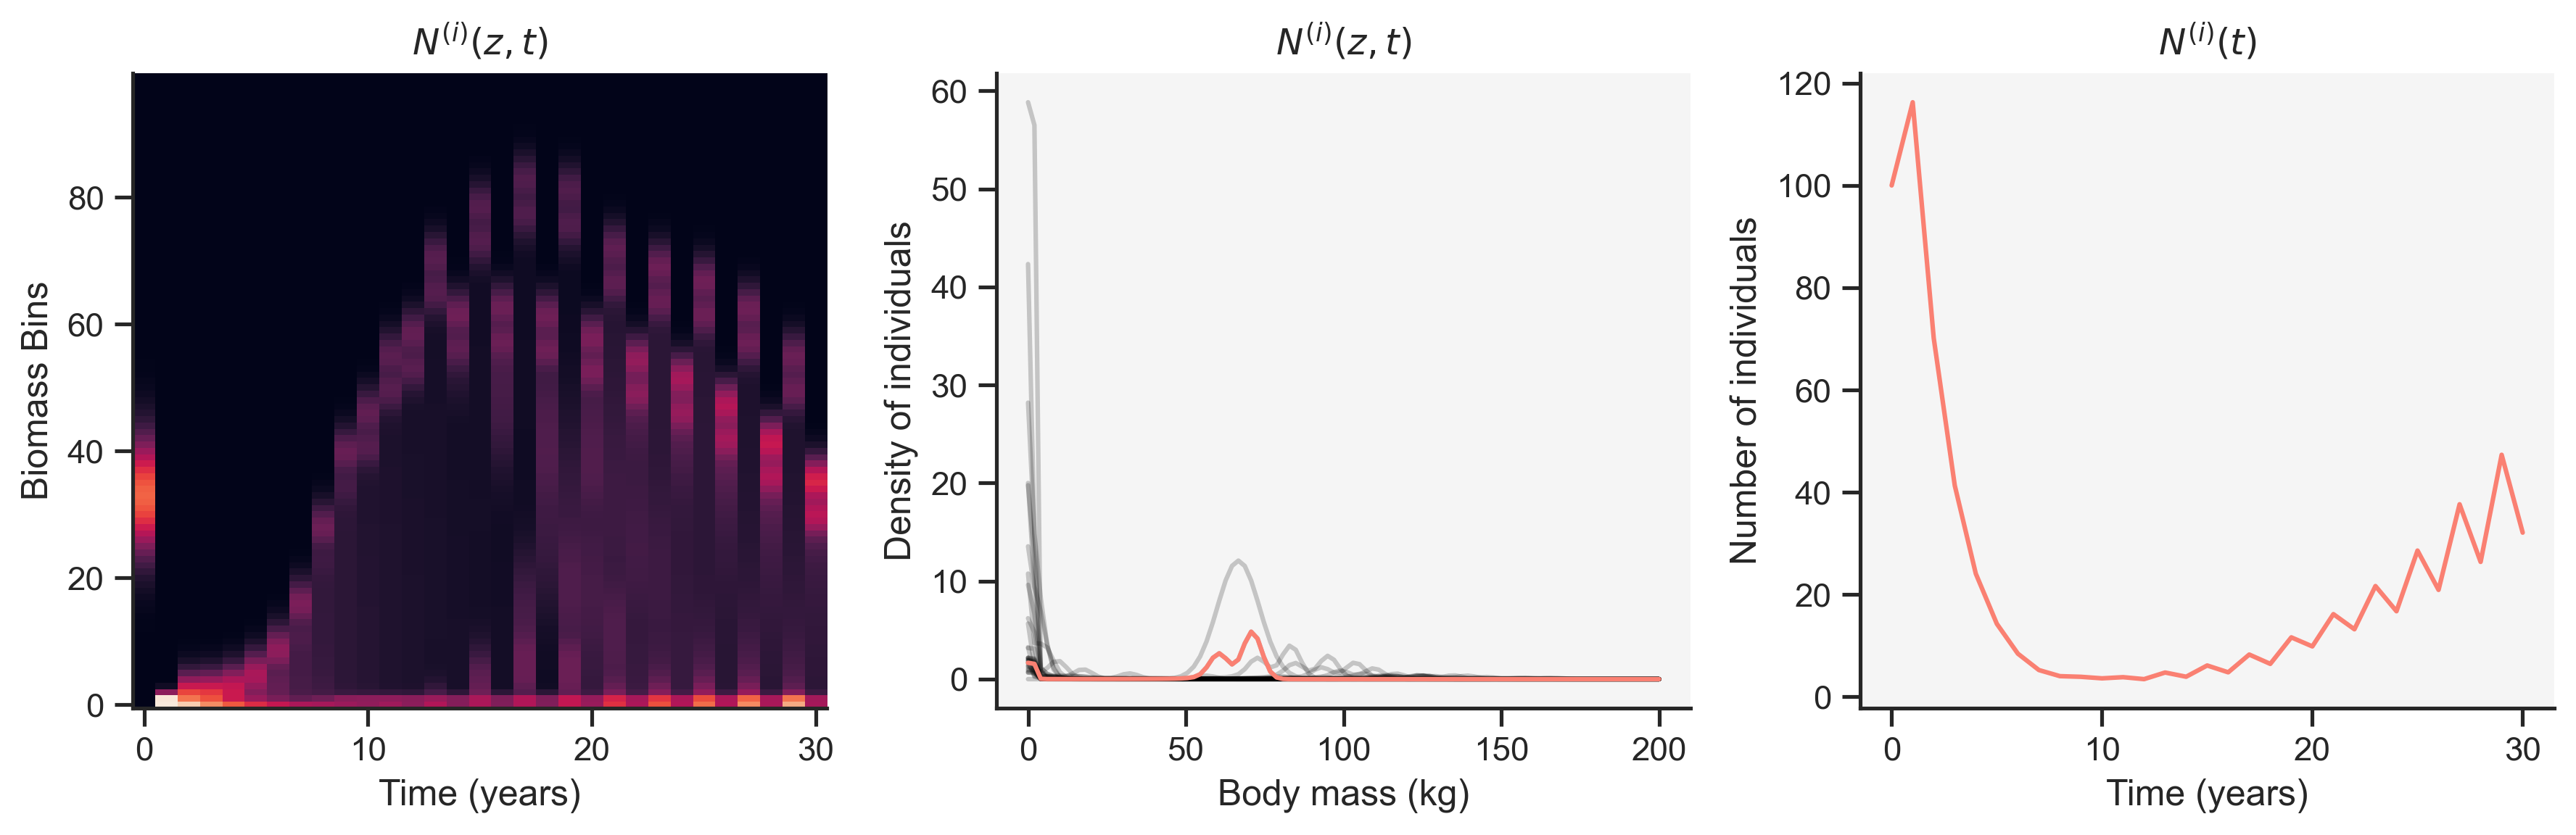

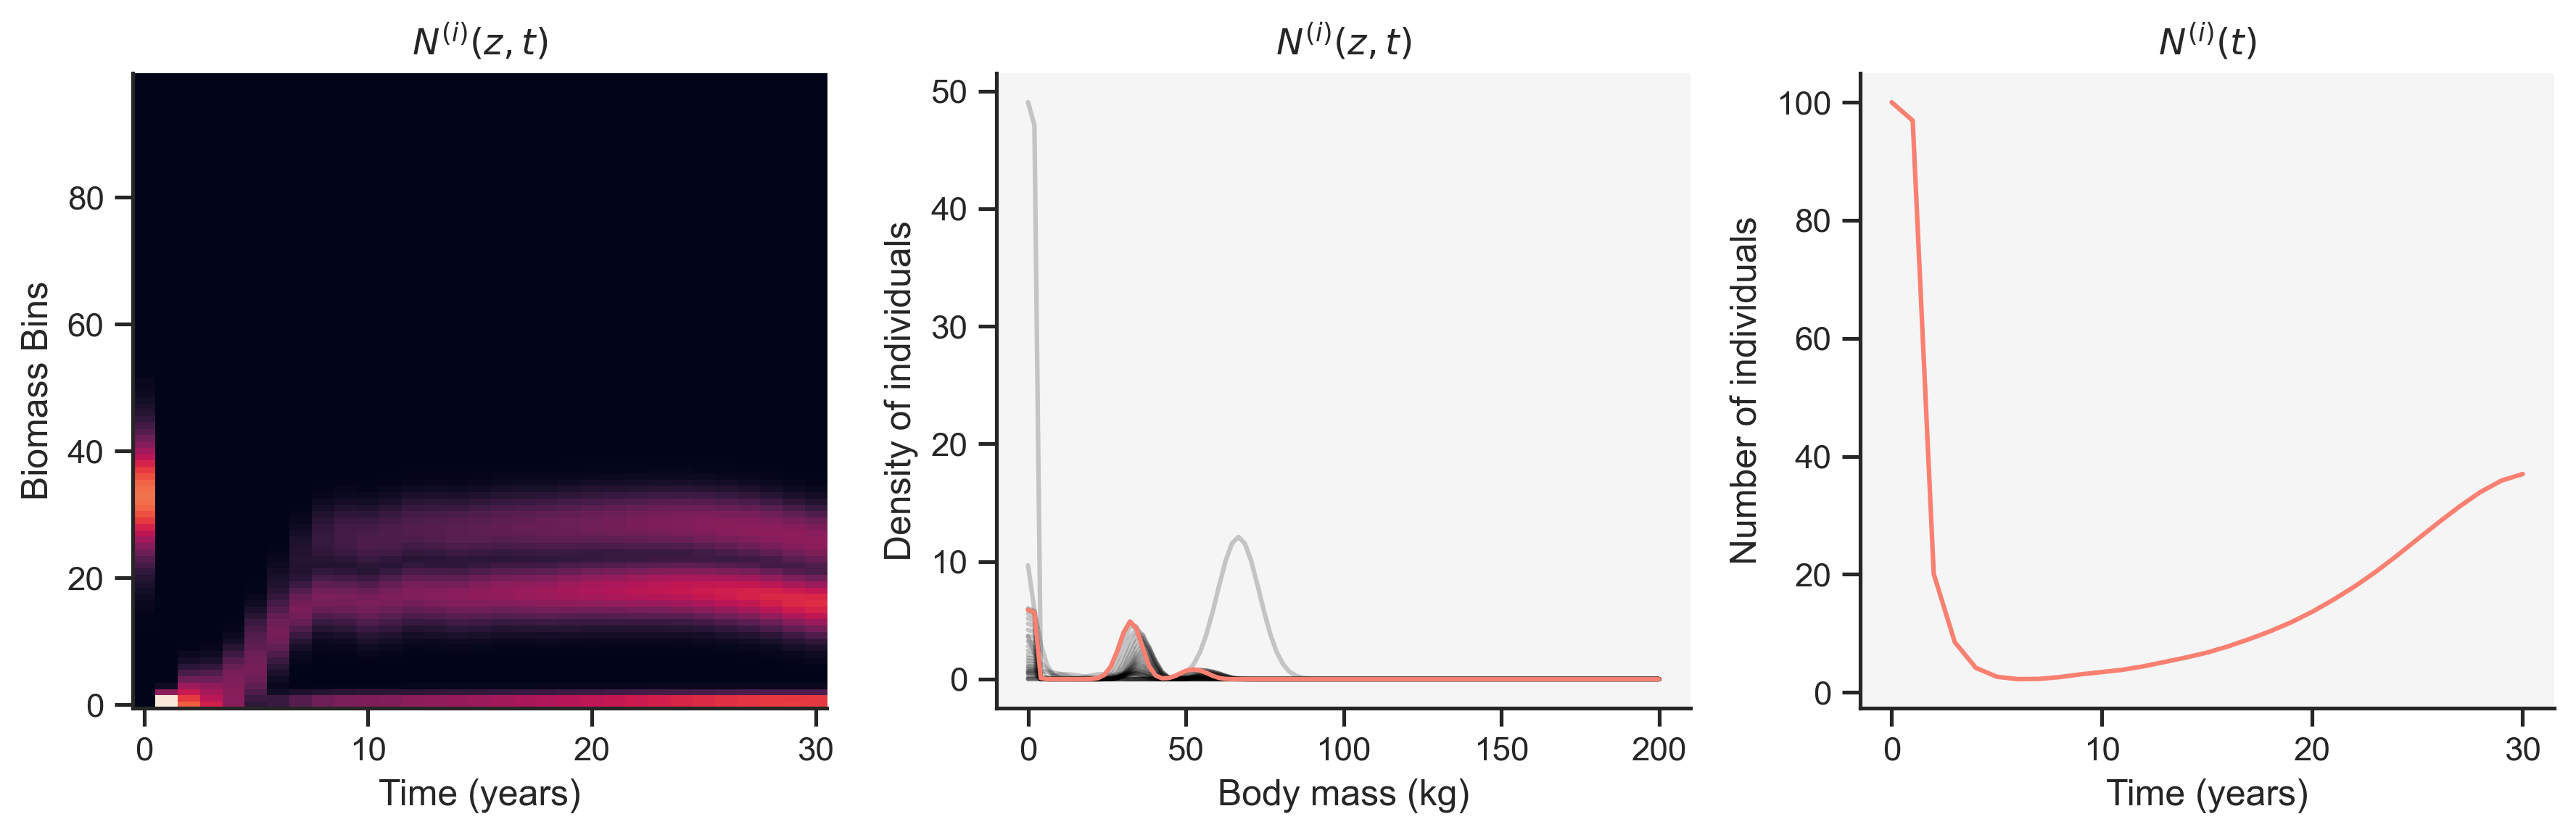

In [22]:
###############
## RUN MODEL ##
###############

## Initiate parameters
t_max_1 = 30

## Hyperparameters
INITIAL_BIOMASS = 15.0
ZZZ_LEN = 100
ZZMAX = [100, 100, 500, 1000, 200, 200]

## Period 1
t0 = time.time()
predictions_1 = model.simulate(t_max=t_max_1,
                             Dt = torch.tensor(INITIAL_BIOMASS*1e9, dtype=torch.float64),
                             Bt = torch.tensor(INITIAL_BIOMASS*1e9, dtype=torch.float64),
                             Pt = torch.tensor(INITIAL_BIOMASS*1e9, dtype=torch.float64),
                             Gt = torch.tensor(INITIAL_BIOMASS*1e9, dtype=torch.float64),
                             NNt = torch.tensor([1*100, 1*100, 1*100, 1*100, 1*100, 1*100], dtype=torch.float64),
                             zzmax = torch.tensor(ZZMAX, dtype=torch.float64),
                             zzz_len = ZZZ_LEN
                            )
zzz, tt, DDt, BBt, PPt, GGt, NNNt, NNNNzt, ttotal_biomass = predictions_1
tf = time.time()
print(f"{tf-t0:.2f}s")

## Visualise
plot_model(predictions_1)

#
###

In [34]:
############################
## EXTIRPATION EXPERIMENT ##
############################

## Initiate parameters
t_max_1 = 200
t_max_2 = 25
t_max_3 = 30

## Hyperparameters
INITIAL_BIOMASS = 15.0
ZZZ_LEN = 100
ZZMAX = [100, 100, 500, 1000, 200, 300]

## Period 1
t0 = time.time()
predictions_1 = model.simulate(t_max=t_max_1,
                             Dt = torch.tensor(INITIAL_BIOMASS*1e9, dtype=torch.float64),
                             Bt = torch.tensor(INITIAL_BIOMASS*1e9, dtype=torch.float64),
                             Pt = torch.tensor(INITIAL_BIOMASS*1e9, dtype=torch.float64),
                             Gt = torch.tensor(INITIAL_BIOMASS*1e9, dtype=torch.float64),
                             NNt = torch.tensor([1*100, 1*100, 1*100, 1*100, 1*100, 1*100], dtype=torch.float64),
                             zzmax = torch.tensor(ZZMAX, dtype=torch.float64),
                             zzz_len = ZZZ_LEN
                            )
zzz, tt, DDt, BBt, PPt, GGt, NNNt, NNNNzt, ttotal_biomass = predictions_1
tf = time.time()
print(f"{tf-t0:.2f}s")

## Extirpate wolves and cougars
NNt_1 = NNNt[-1].clone().detach()
NNNzt_1 = NNNNzt[-1].clone().detach()
#
## Wolves
NNt_1[4] *= torch.tensor(0.0, dtype=torch.float64)
NNNzt_1[4] *= torch.tensor(0.0, dtype=torch.float64)
#
## Cougars
# NNt_1[5] *= torch.tensor(0.0, dtype=torch.float64)
# NNNzt_1[5] *= torch.tensor(0.0, dtype=torch.float64)

## Period 2
t0 = time.time()
predictions_2 = model.simulate(t_max=t_max_2,
                             Dt = DDt[-1].clone().detach(),
                             Bt = BBt[-1].clone().detach(),
                             Pt = PPt[-1].clone().detach(),
                             Gt = GGt[-1].clone().detach(),
                             NNt = NNt_1.clone().detach(),
                             NNNzt = NNNzt_1.clone().detach(),
                             zzmax = torch.tensor(ZZMAX, dtype=torch.float64),
                             zzz_len = ZZZ_LEN
                            )
zzz, tt, DDt, BBt, PPt, GGt, NNNt, NNNNzt, ttotal_biomass = predictions_2
tf = time.time()
print(f"{tf-t0:.2f}s")

## Re-introduce wolves and cougars
NNt_2 = NNNt[-1].clone().detach()
NNNzt_2 = NNNNzt[-1].clone().detach()
#
## Wolves
N_introduced = torch.tensor(30.0, dtype=torch.float64)
Z_mean_introduced = torch.tensor(30.0, dtype=torch.float64)
Z_std_introduced = torch.tensor(3.0, dtype=torch.float64)
NNt_2[4] = N_introduced.clone().detach()
NNNzt_2[4] = (N_introduced * pdf(f_normal(zzz[4].clone().detach(), Z_mean_introduced, Z_std_introduced))).clone().detach()
#
## Cougars
# N_introduced = torch.tensor(30.0, dtype=torch.float64)
# Z_mean_introduced = torch.tensor(30.0, dtype=torch.float64)
# Z_std_introduced = torch.tensor(3.0, dtype=torch.float64)
# NNt_2[5] = N_introduced.clone().detach()
# NNNzt_2[5] = (N_introduced * pdf(f_normal(zzz[5].clone().detach(), Z_mean_introduced, Z_std_introduced))).clone().detach()

#
###

4.49s
0.49s


In [35]:
#############################
## SAVE INITIAL CONDITIONS ##
#############################

import yaml
import torch

# Example initial conditions (you can replace these with your actual tensor values)
initial_conditions = {
    'Dt0': DDt[-1].clone().detach().tolist(),
    'Bt0': BBt[-1].clone().detach().tolist(),
    'Pt0': PPt[-1].clone().detach().tolist(),
    'Gt0': GGt[-1].clone().detach().tolist(),
    'NNt0': NNt_2.clone().detach().tolist(),
    'NNNzt0': NNNzt_2.clone().detach().tolist(),
}

settings = {
    'zzmax': ZZMAX,
    'zzz_len': ZZZ_LEN
}

# Write to a YAML file
with open('initial-conditions-V1-14-2025-09-30.yaml', 'w') as file:
    yaml.dump(initial_conditions, file)
with open('settings-V1-14-2025-09-30.yaml', 'w') as file:
    yaml.dump(settings, file)

#
###

In [36]:
## Period 3
t0 = time.time()
predictions_3 = model.simulate(t_max=t_max_3,
                             Dt = DDt[-1].clone().detach(),
                             Bt = BBt[-1].clone().detach(),
                             Pt = PPt[-1].clone().detach(),
                             Gt = GGt[-1].clone().detach(),
                             NNt = NNt_2.clone().detach(),
                             NNNzt = NNNzt_2.clone().detach(),
                             zzmax = torch.tensor(ZZMAX, dtype=torch.float64),
                             zzz_len = ZZZ_LEN
                            )
zzz, tt, DDt, BBt, PPt, GGt, NNNt, NNNNzt, ttotal_biomass = predictions_3
tf = time.time()
print(f"{tf-t0:.2f}s")

#
###

0.72s


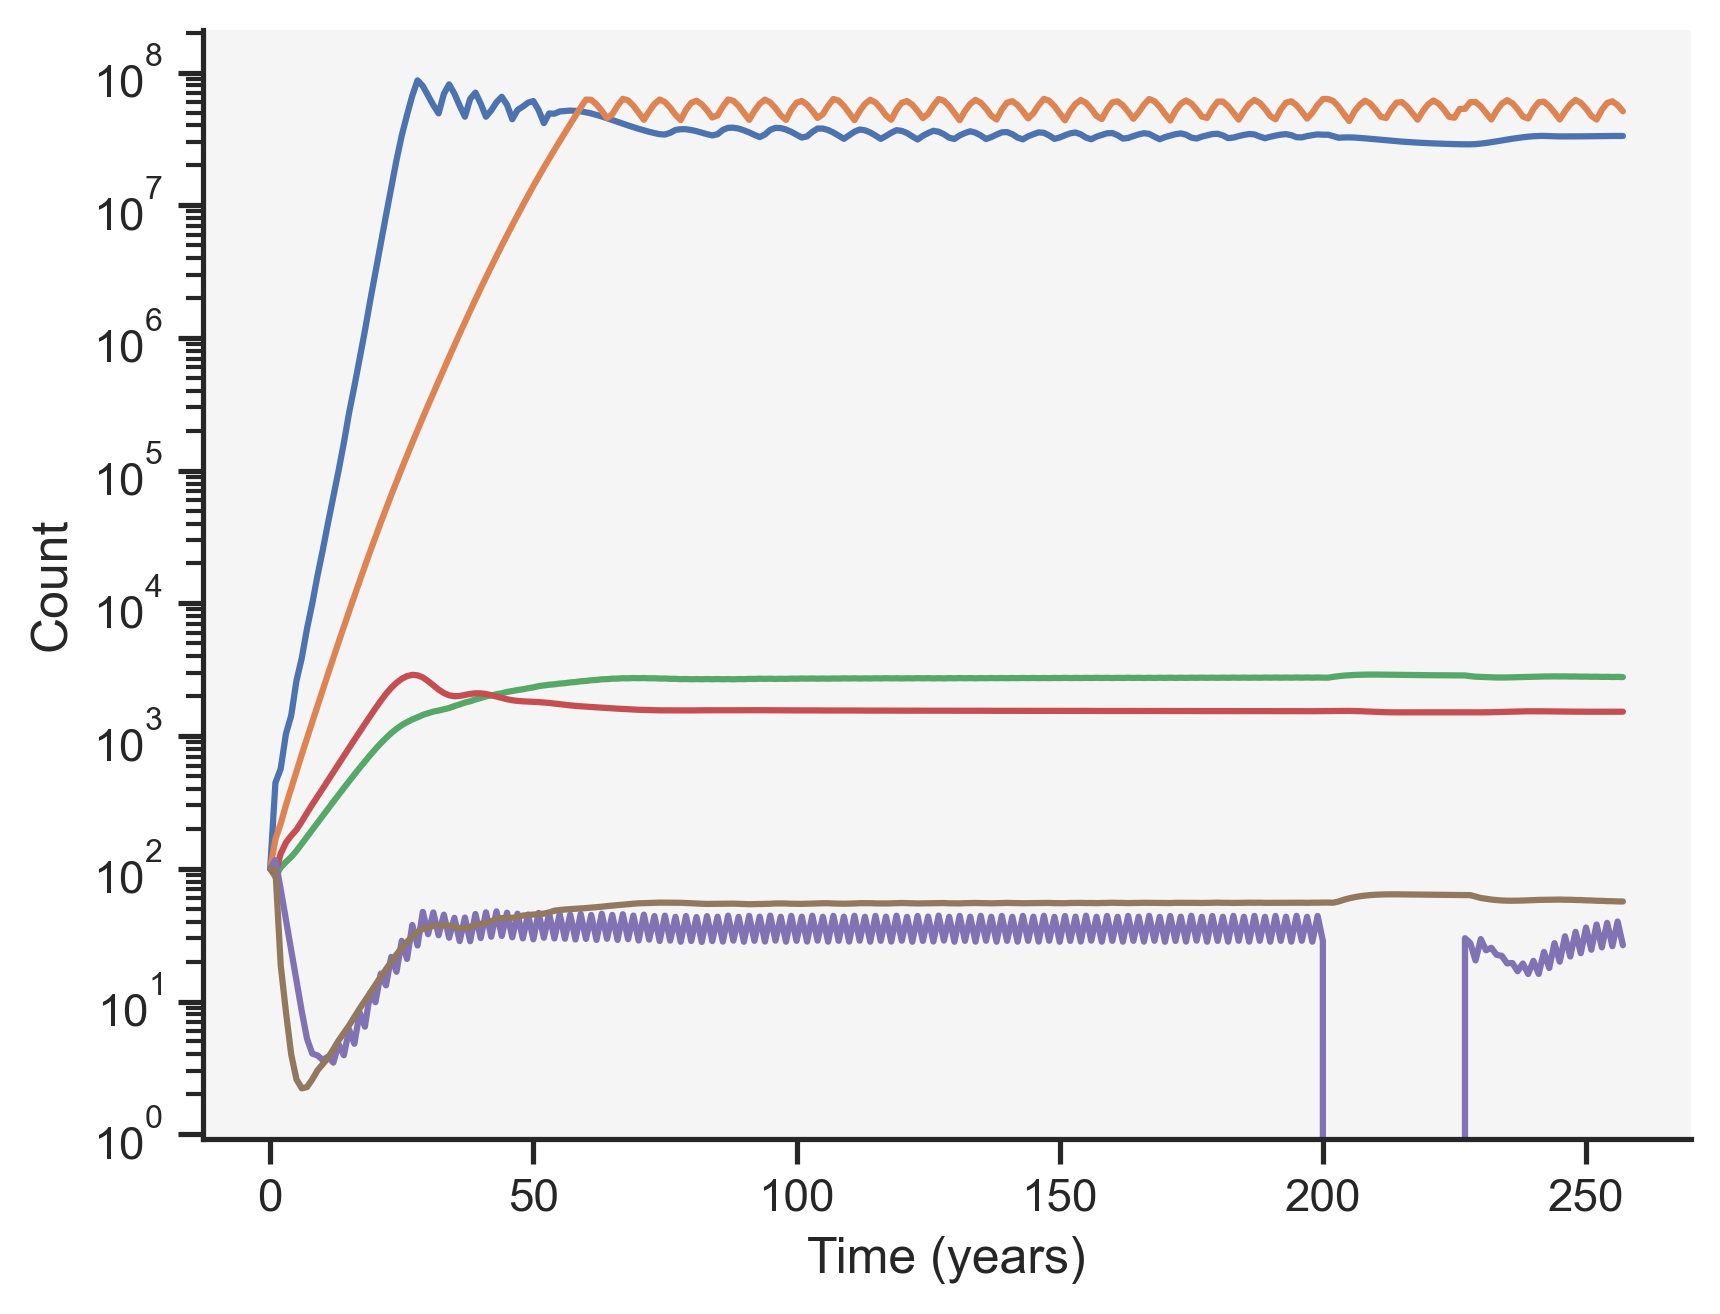

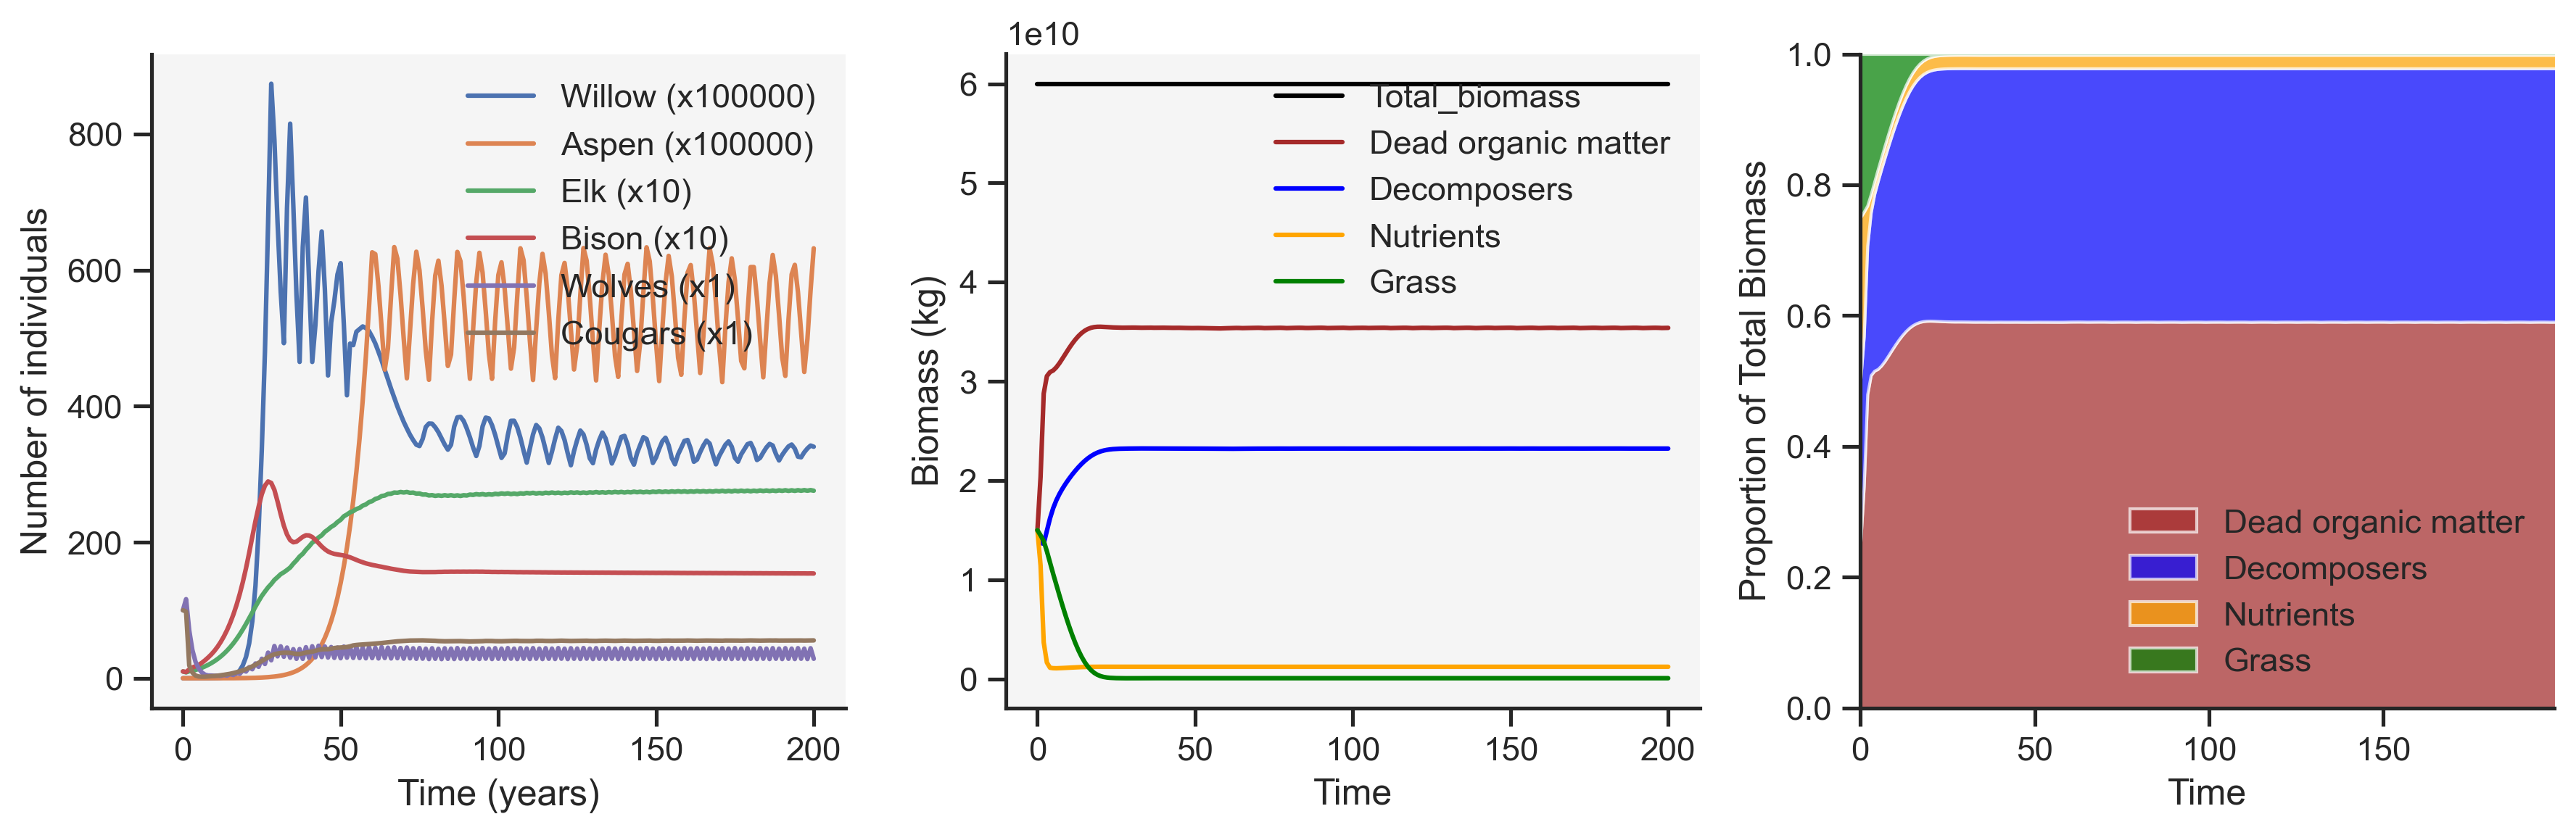

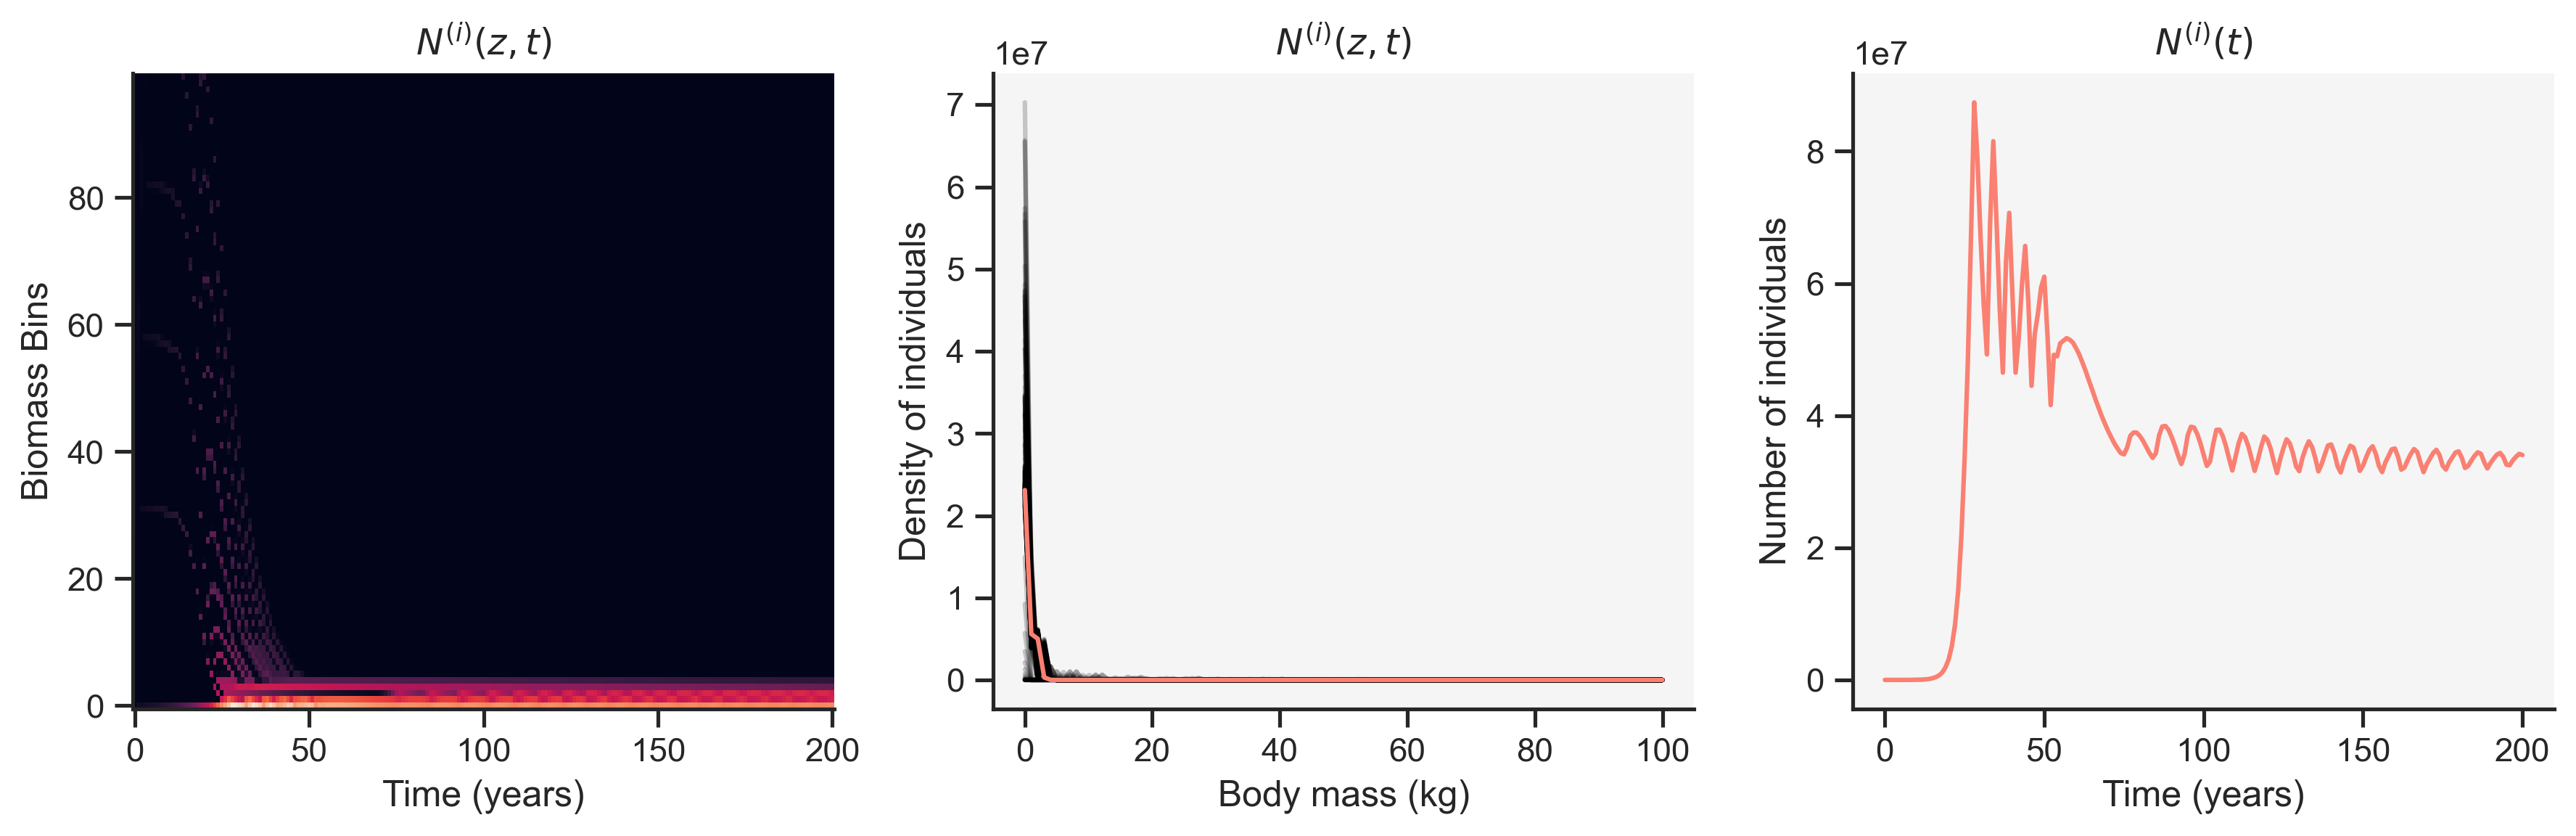

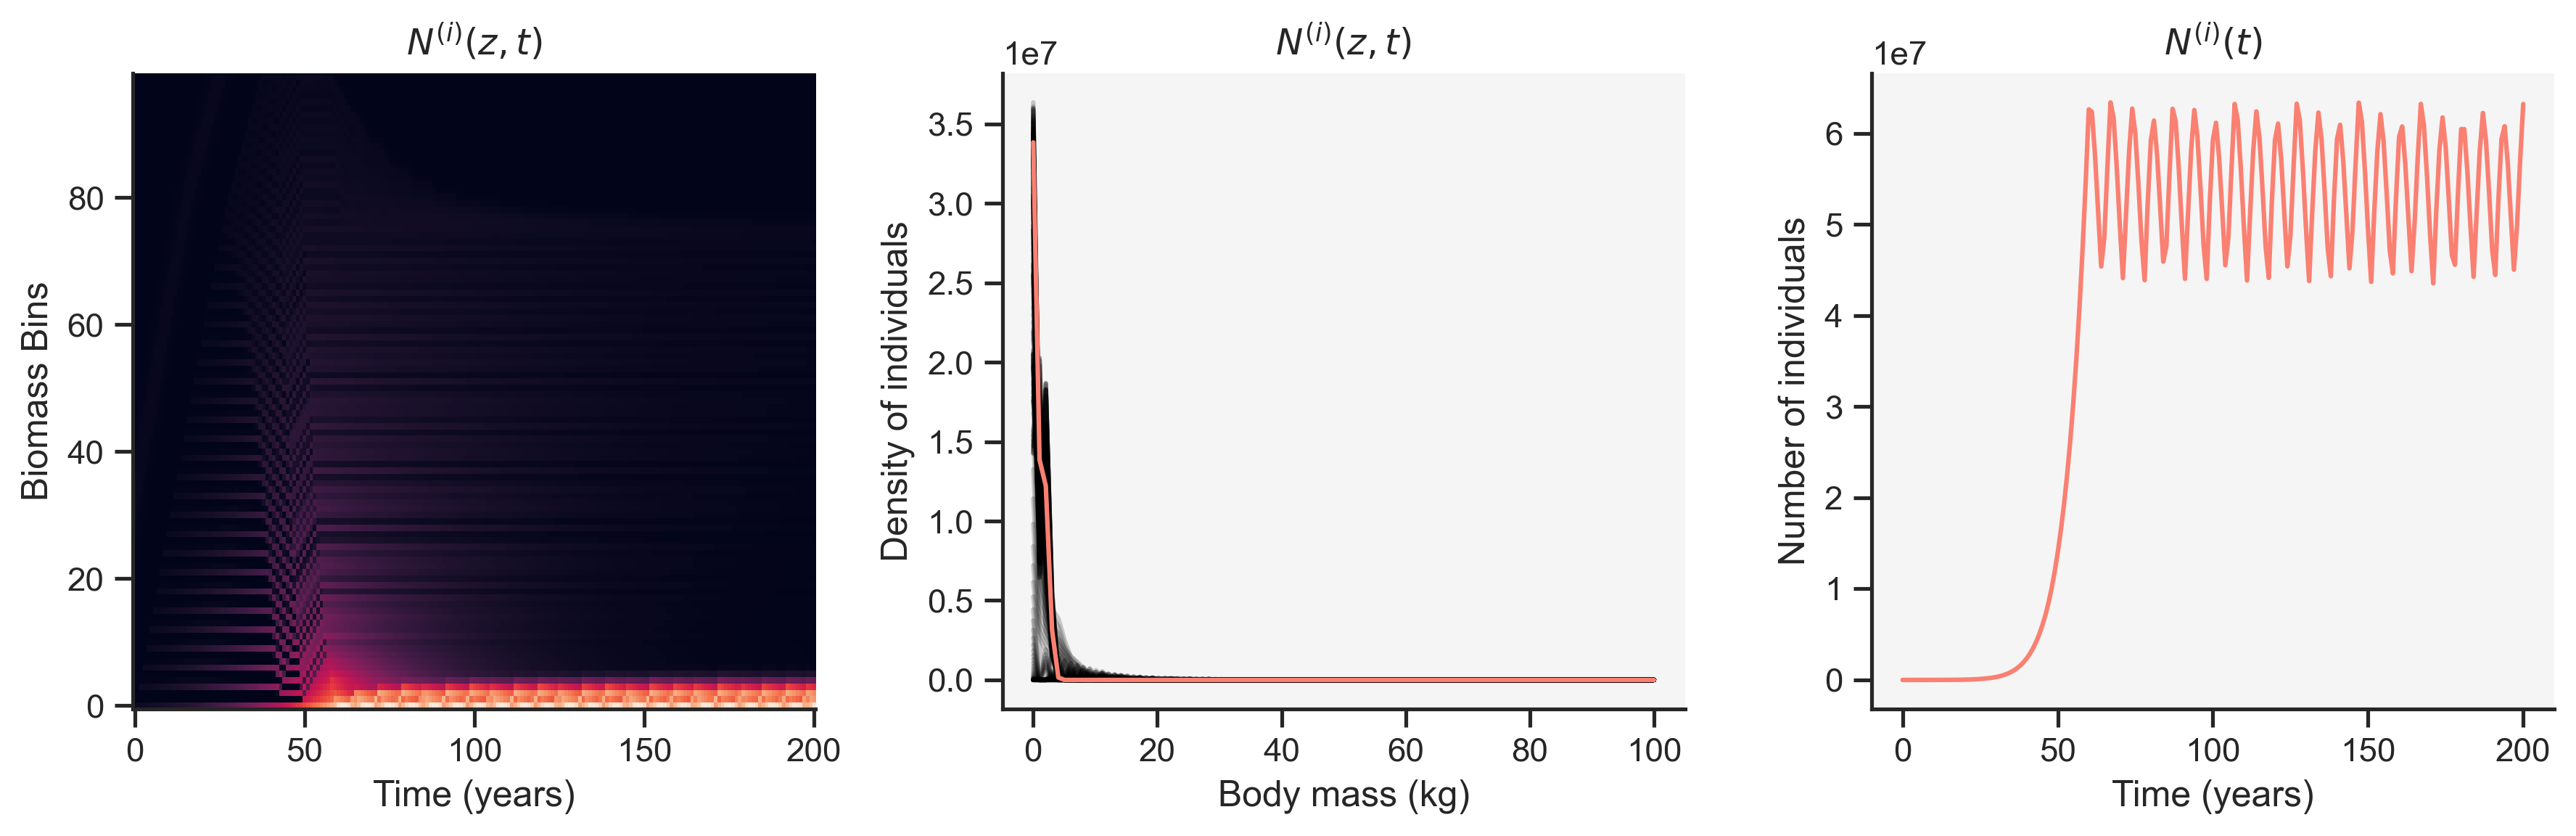

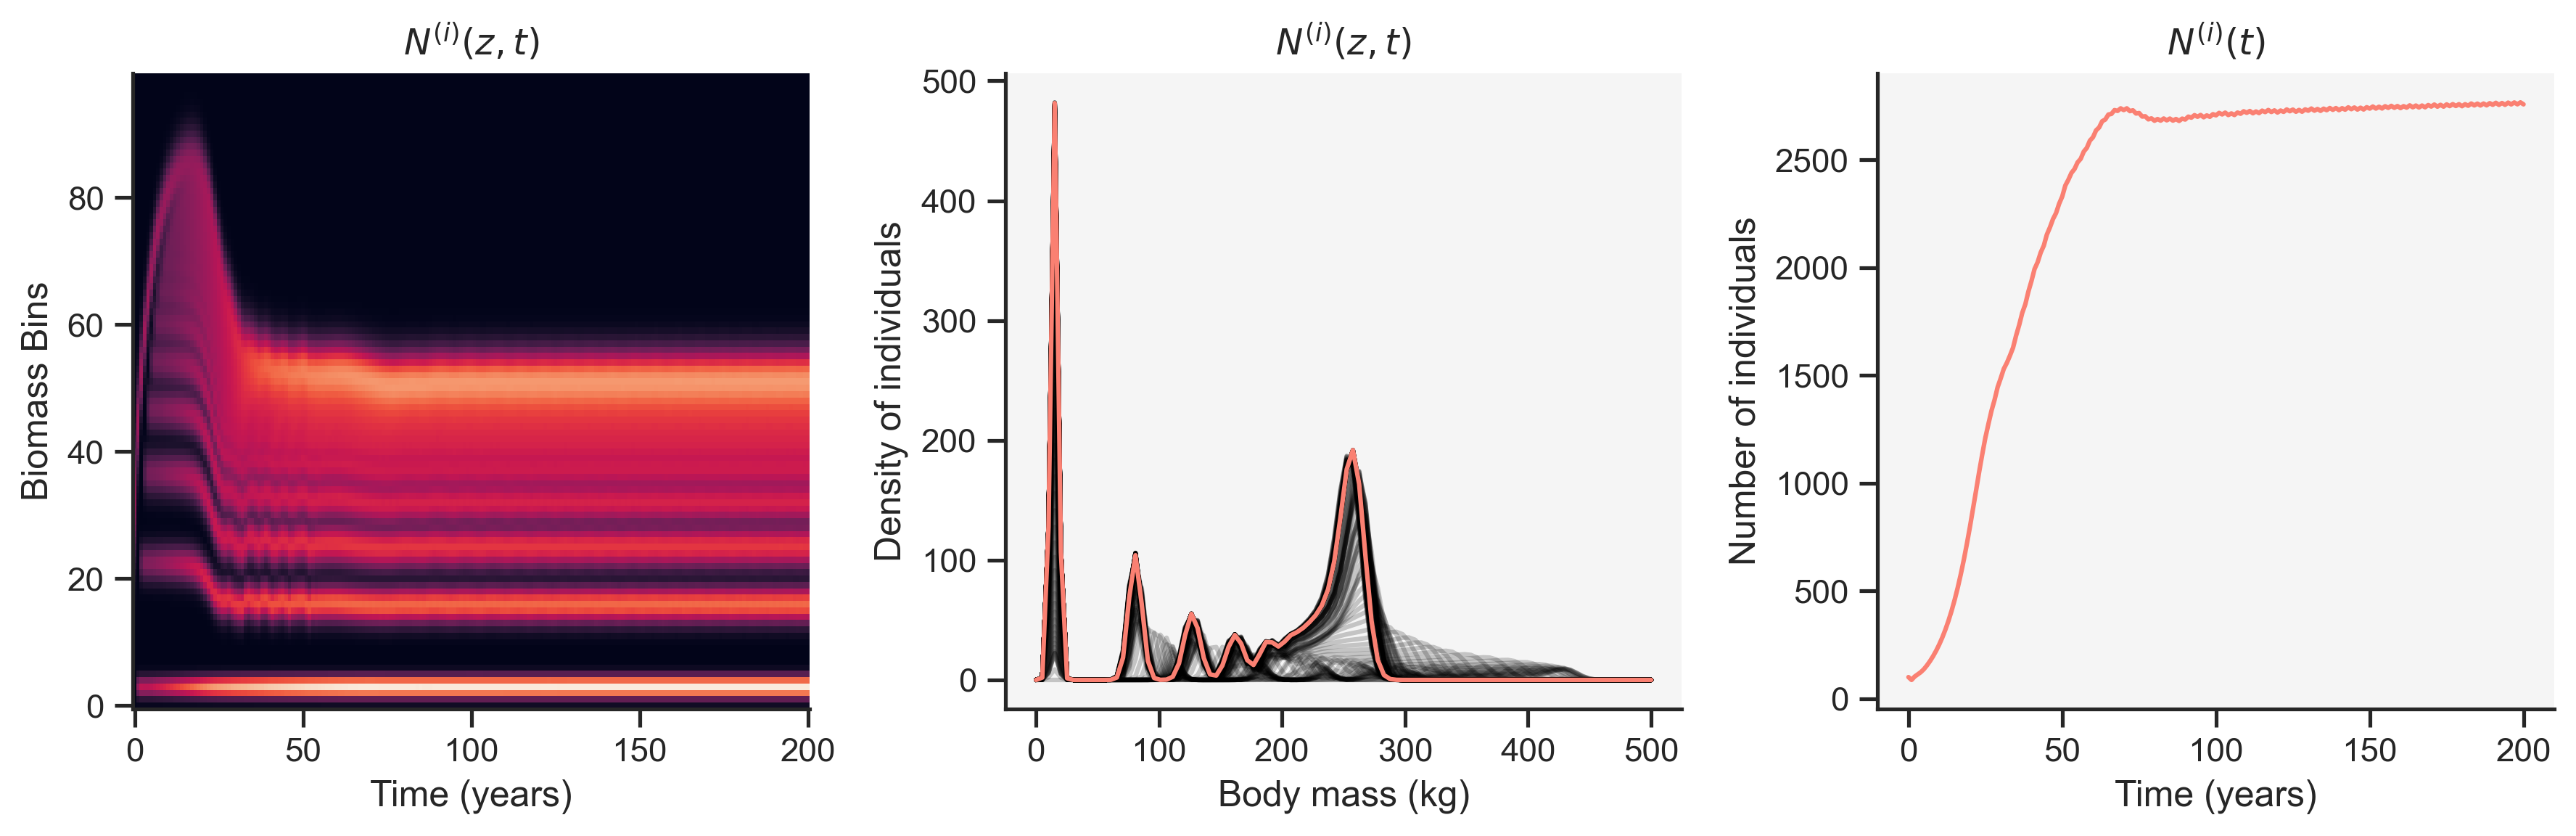

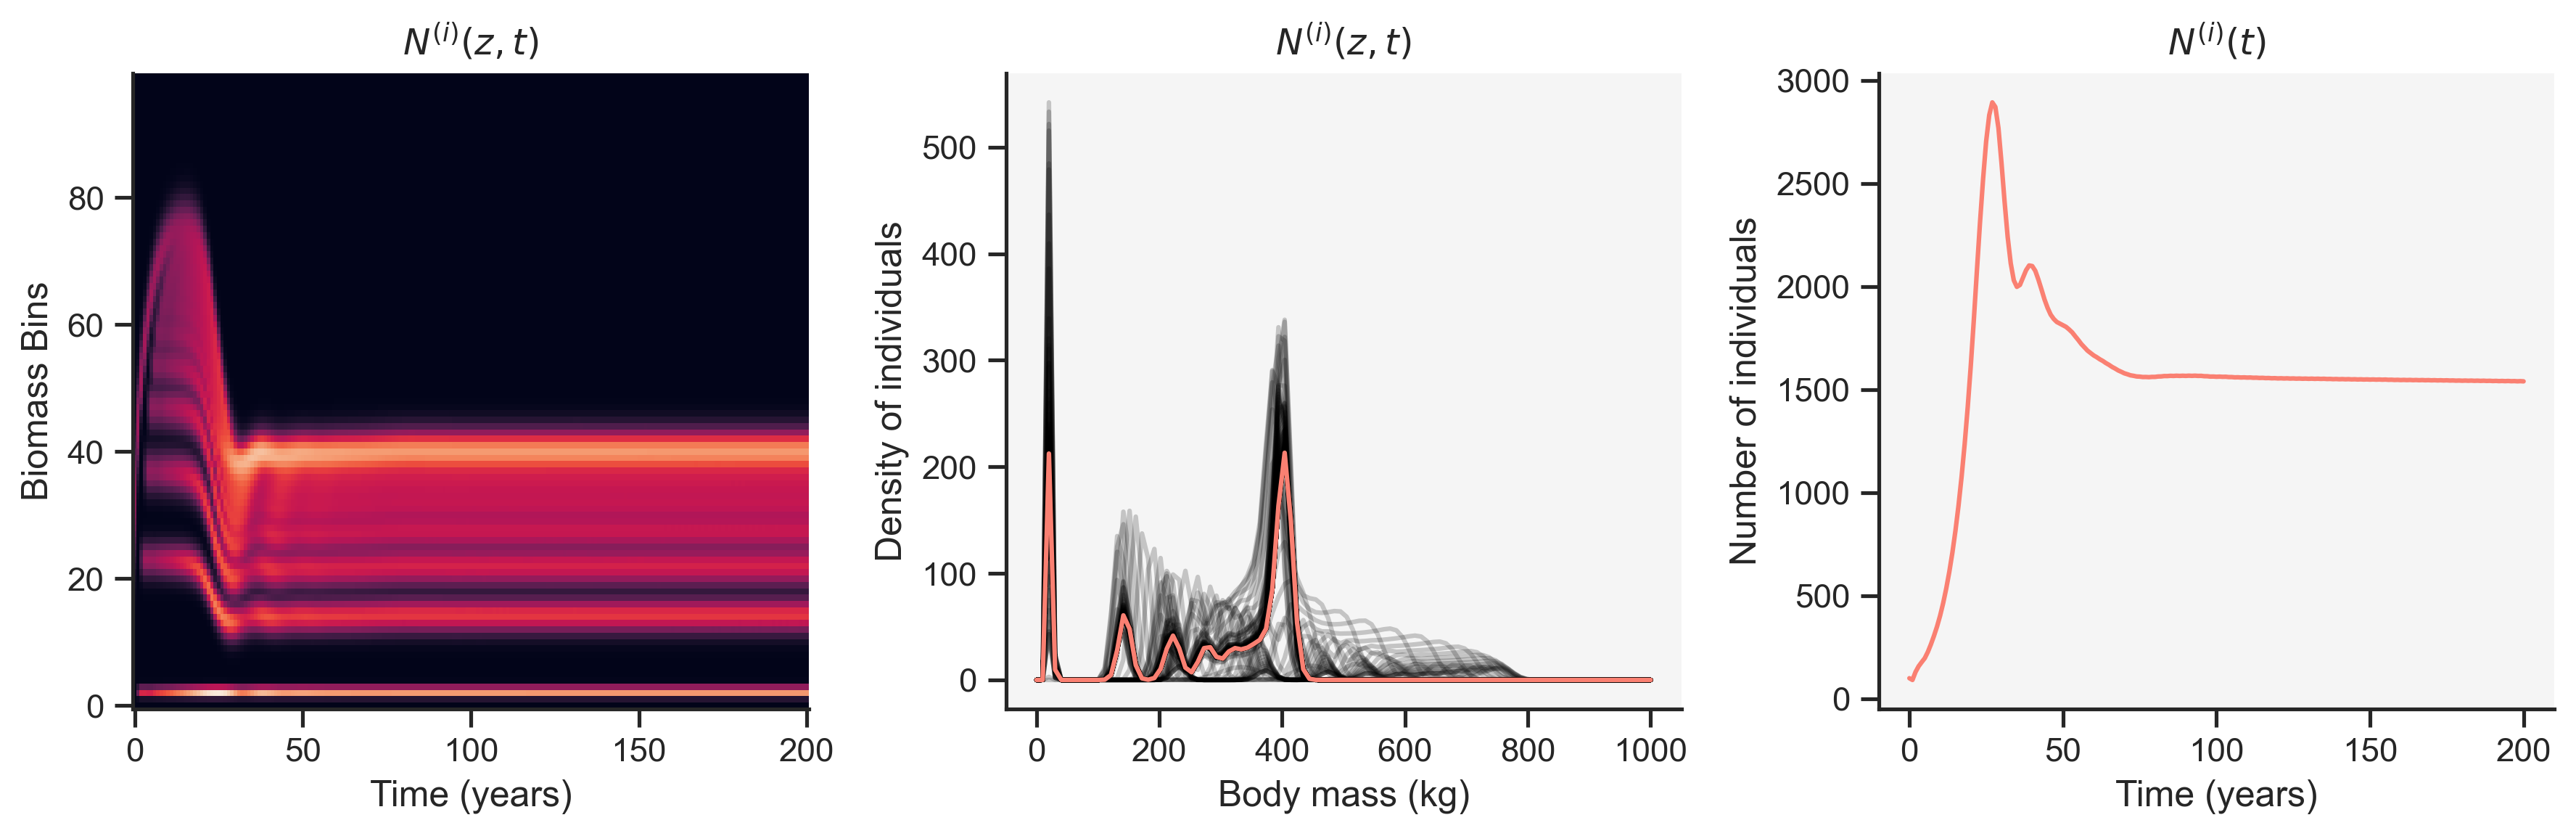

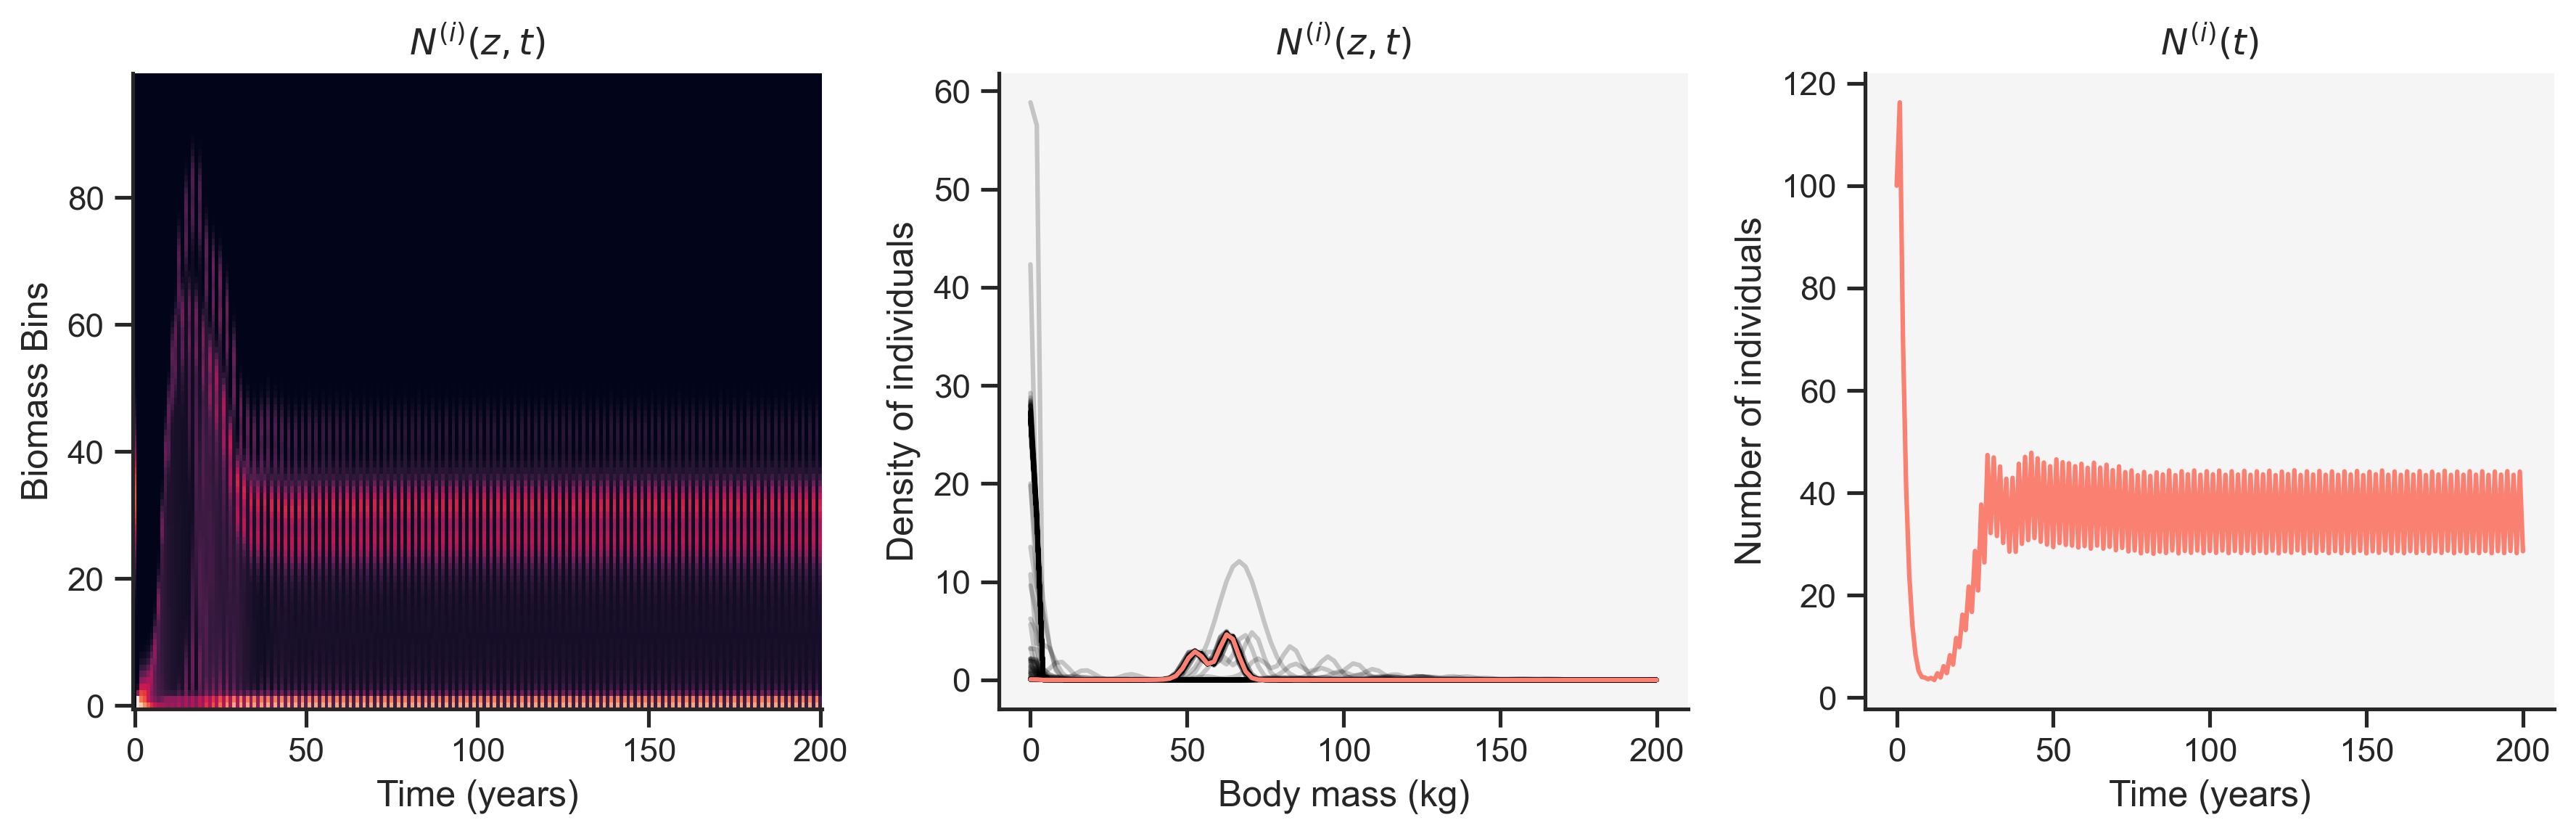

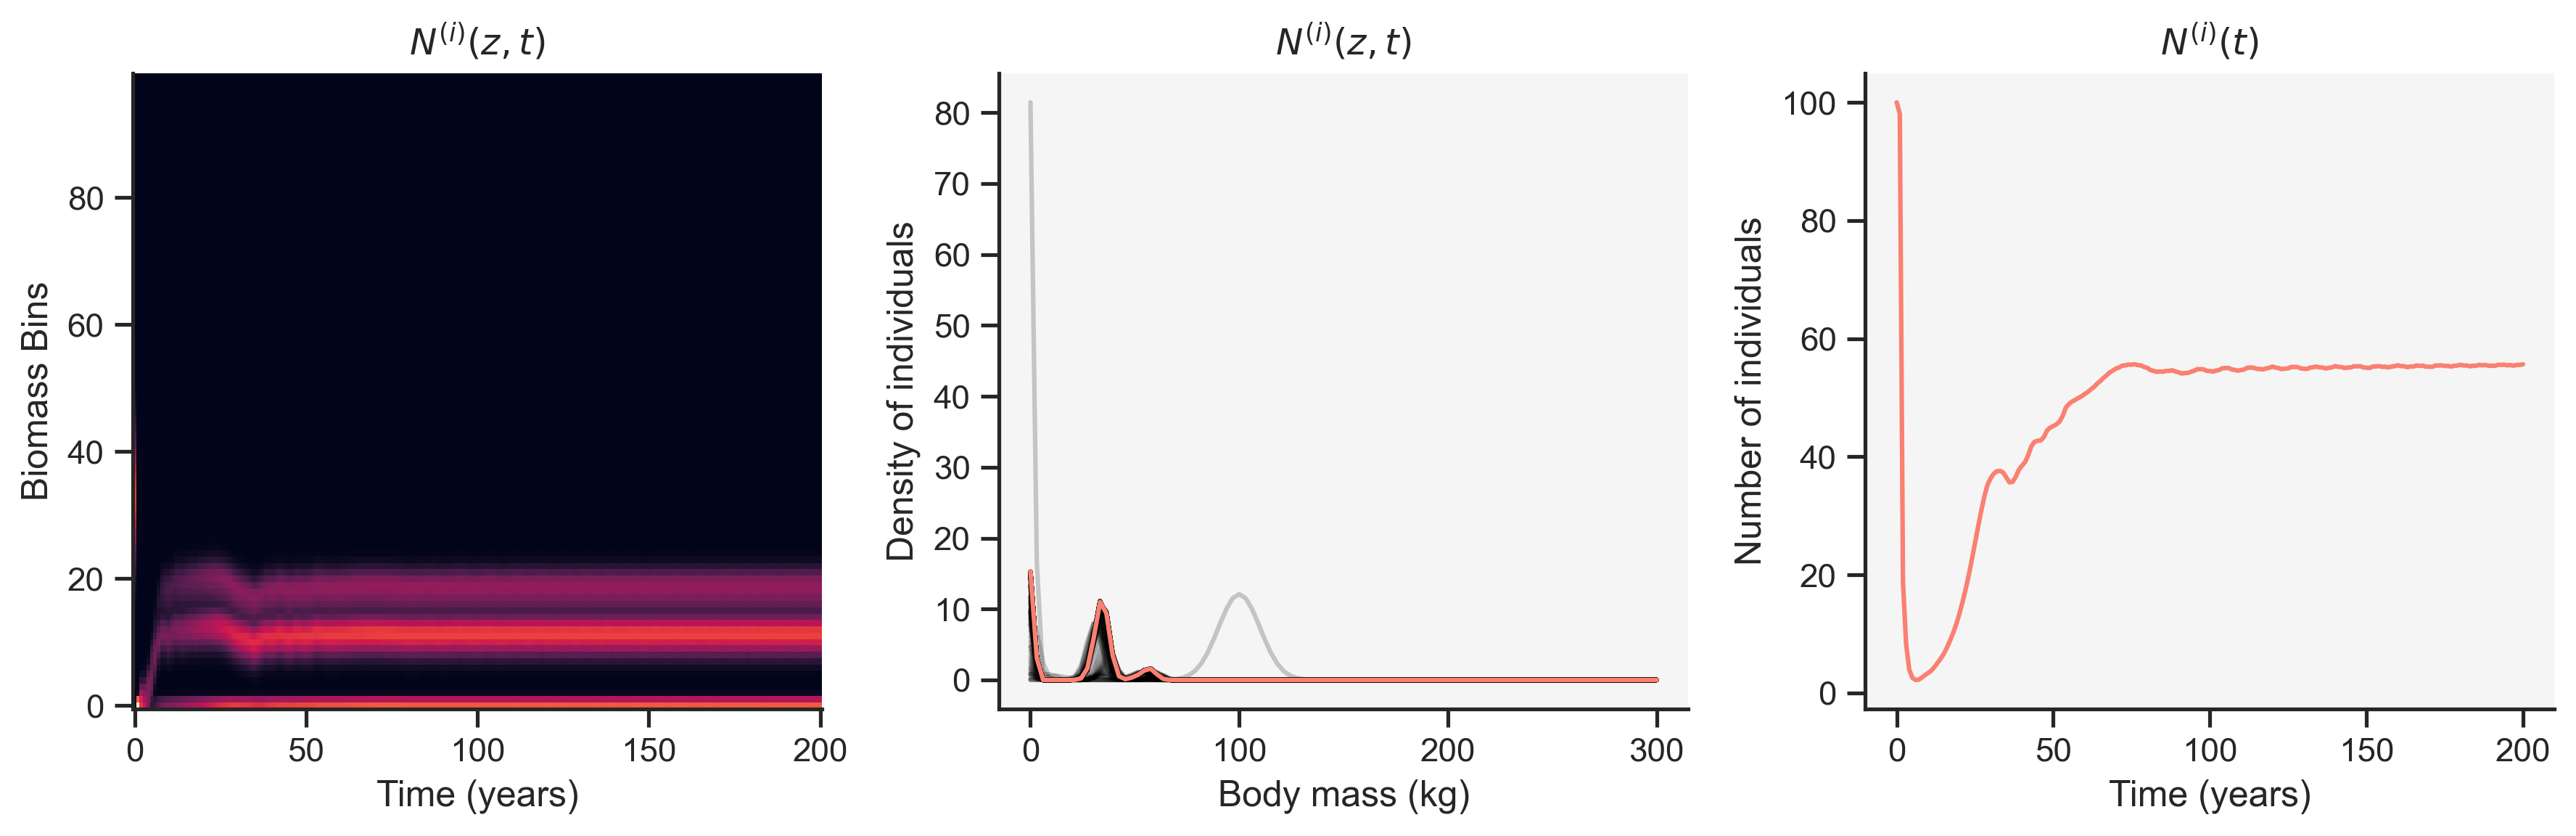

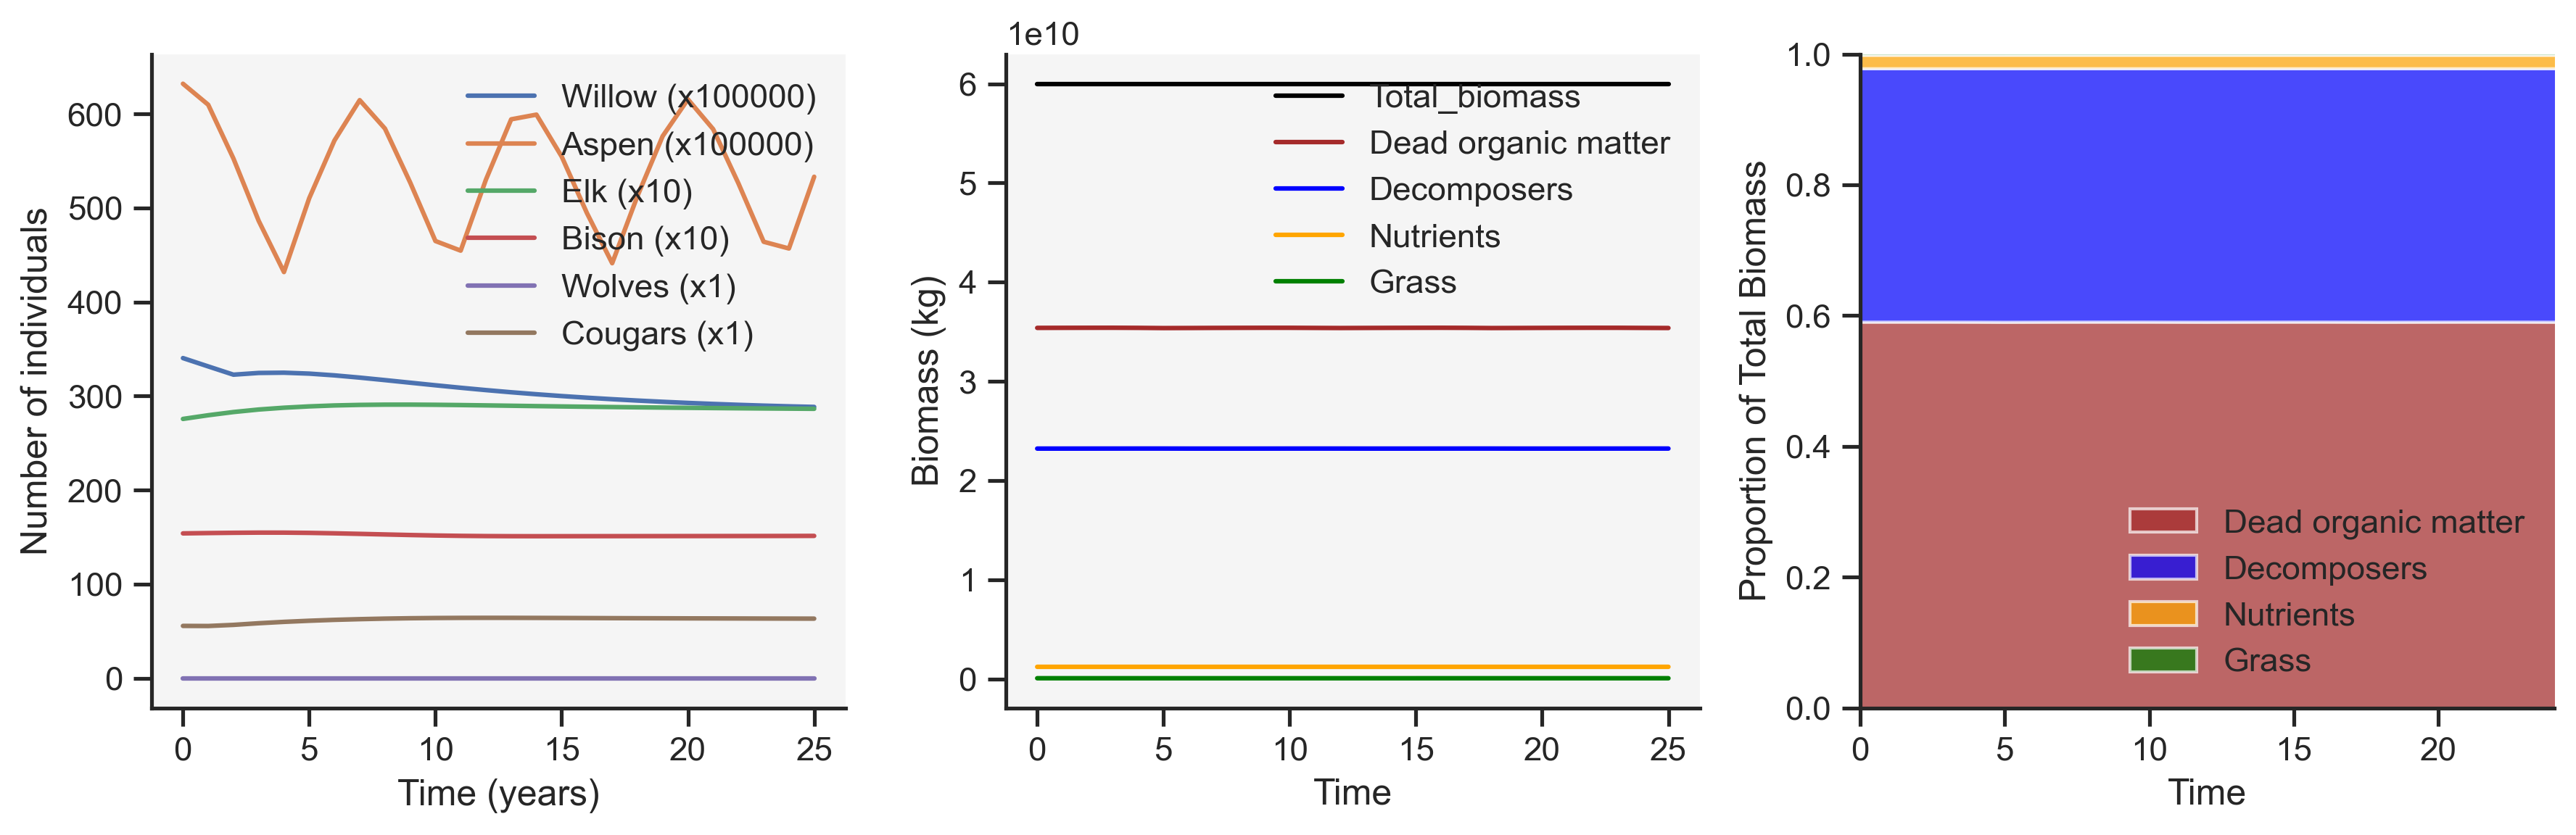

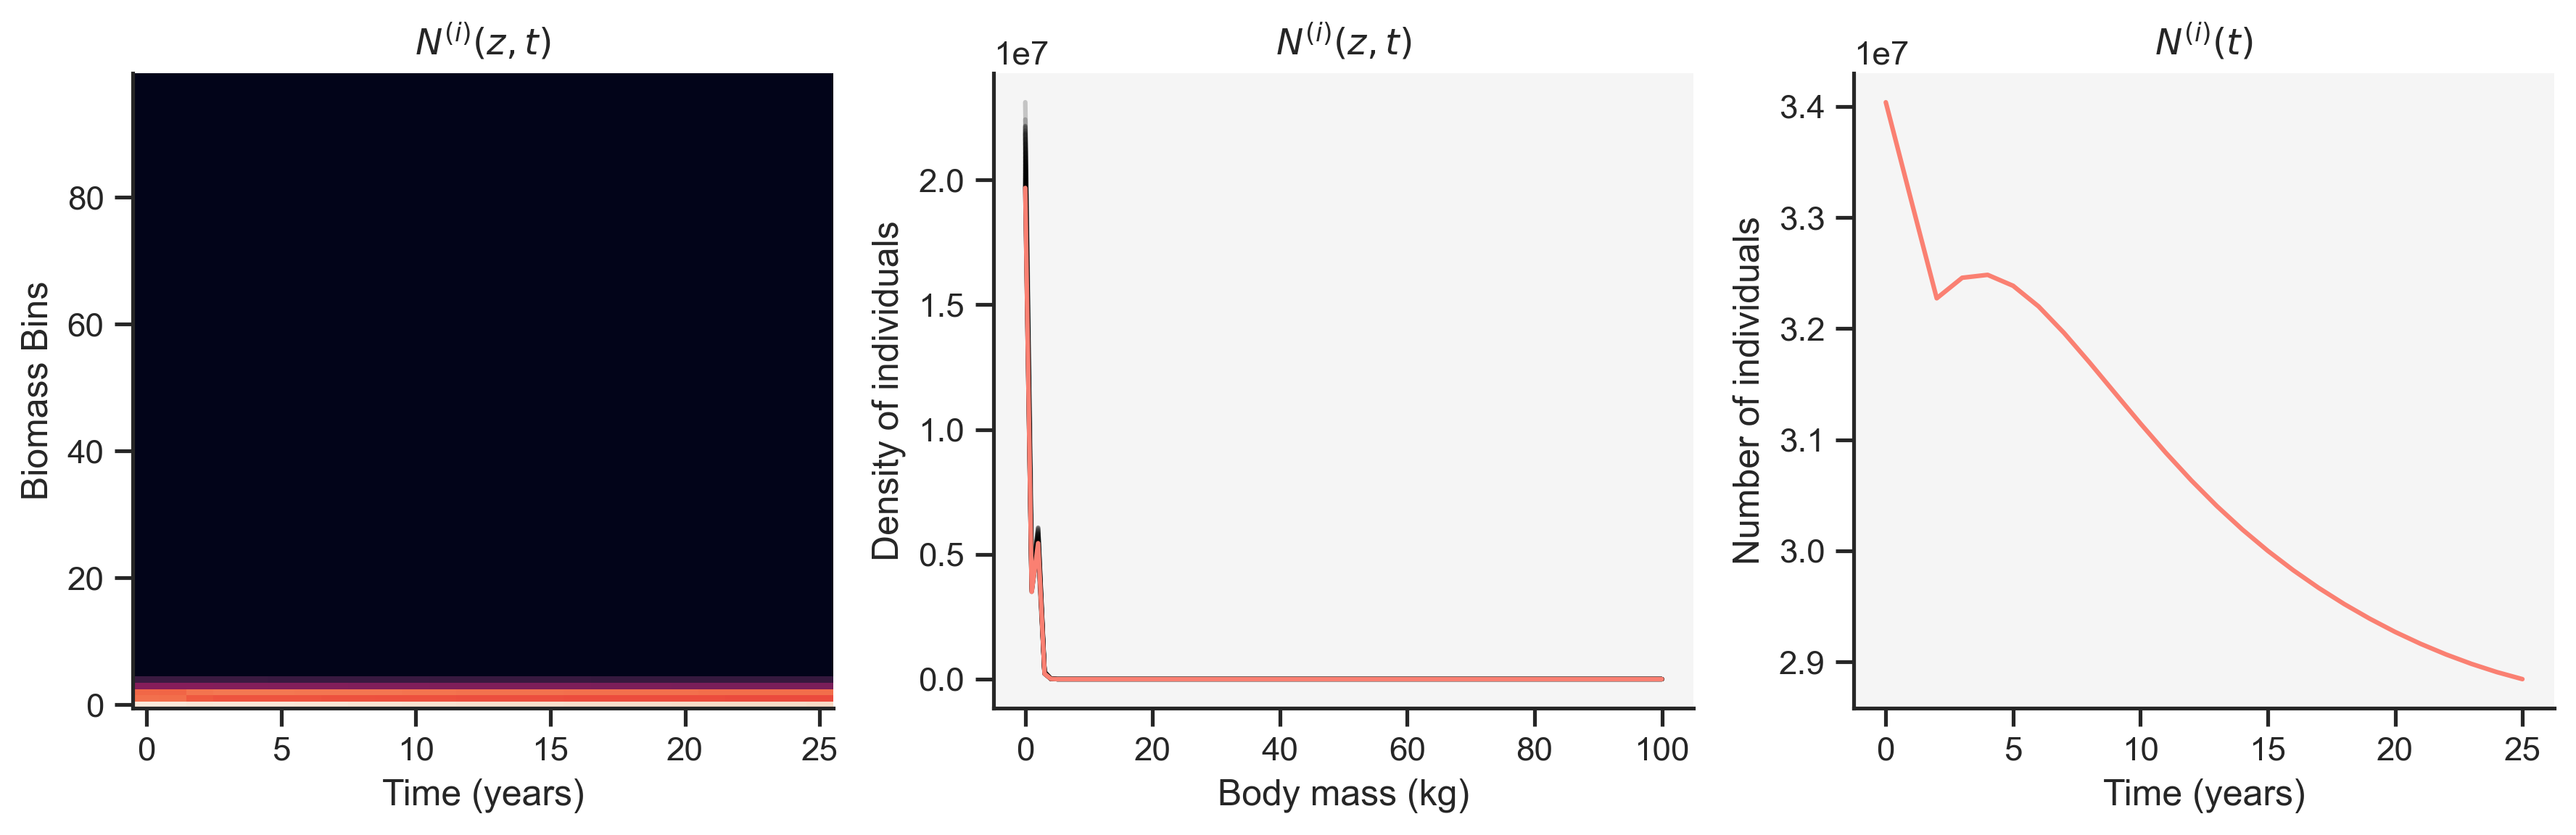

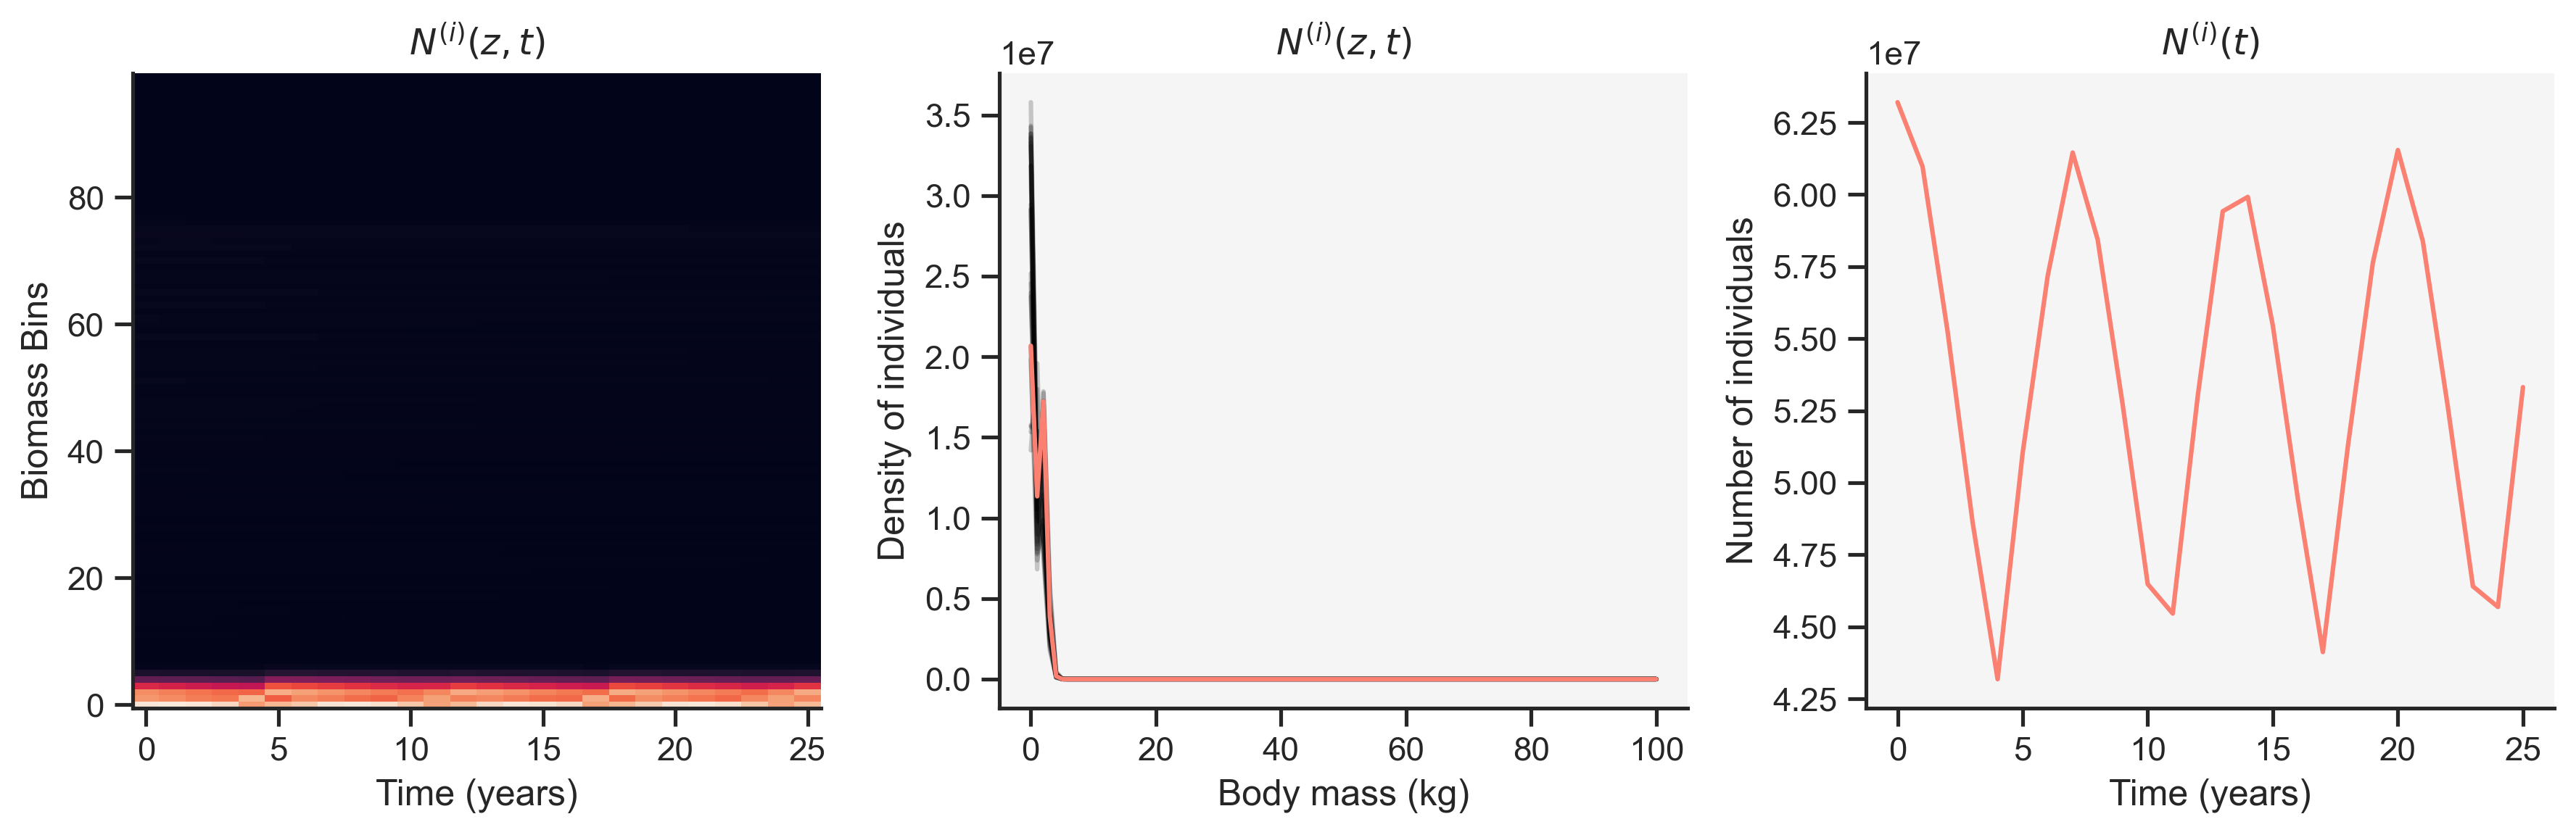

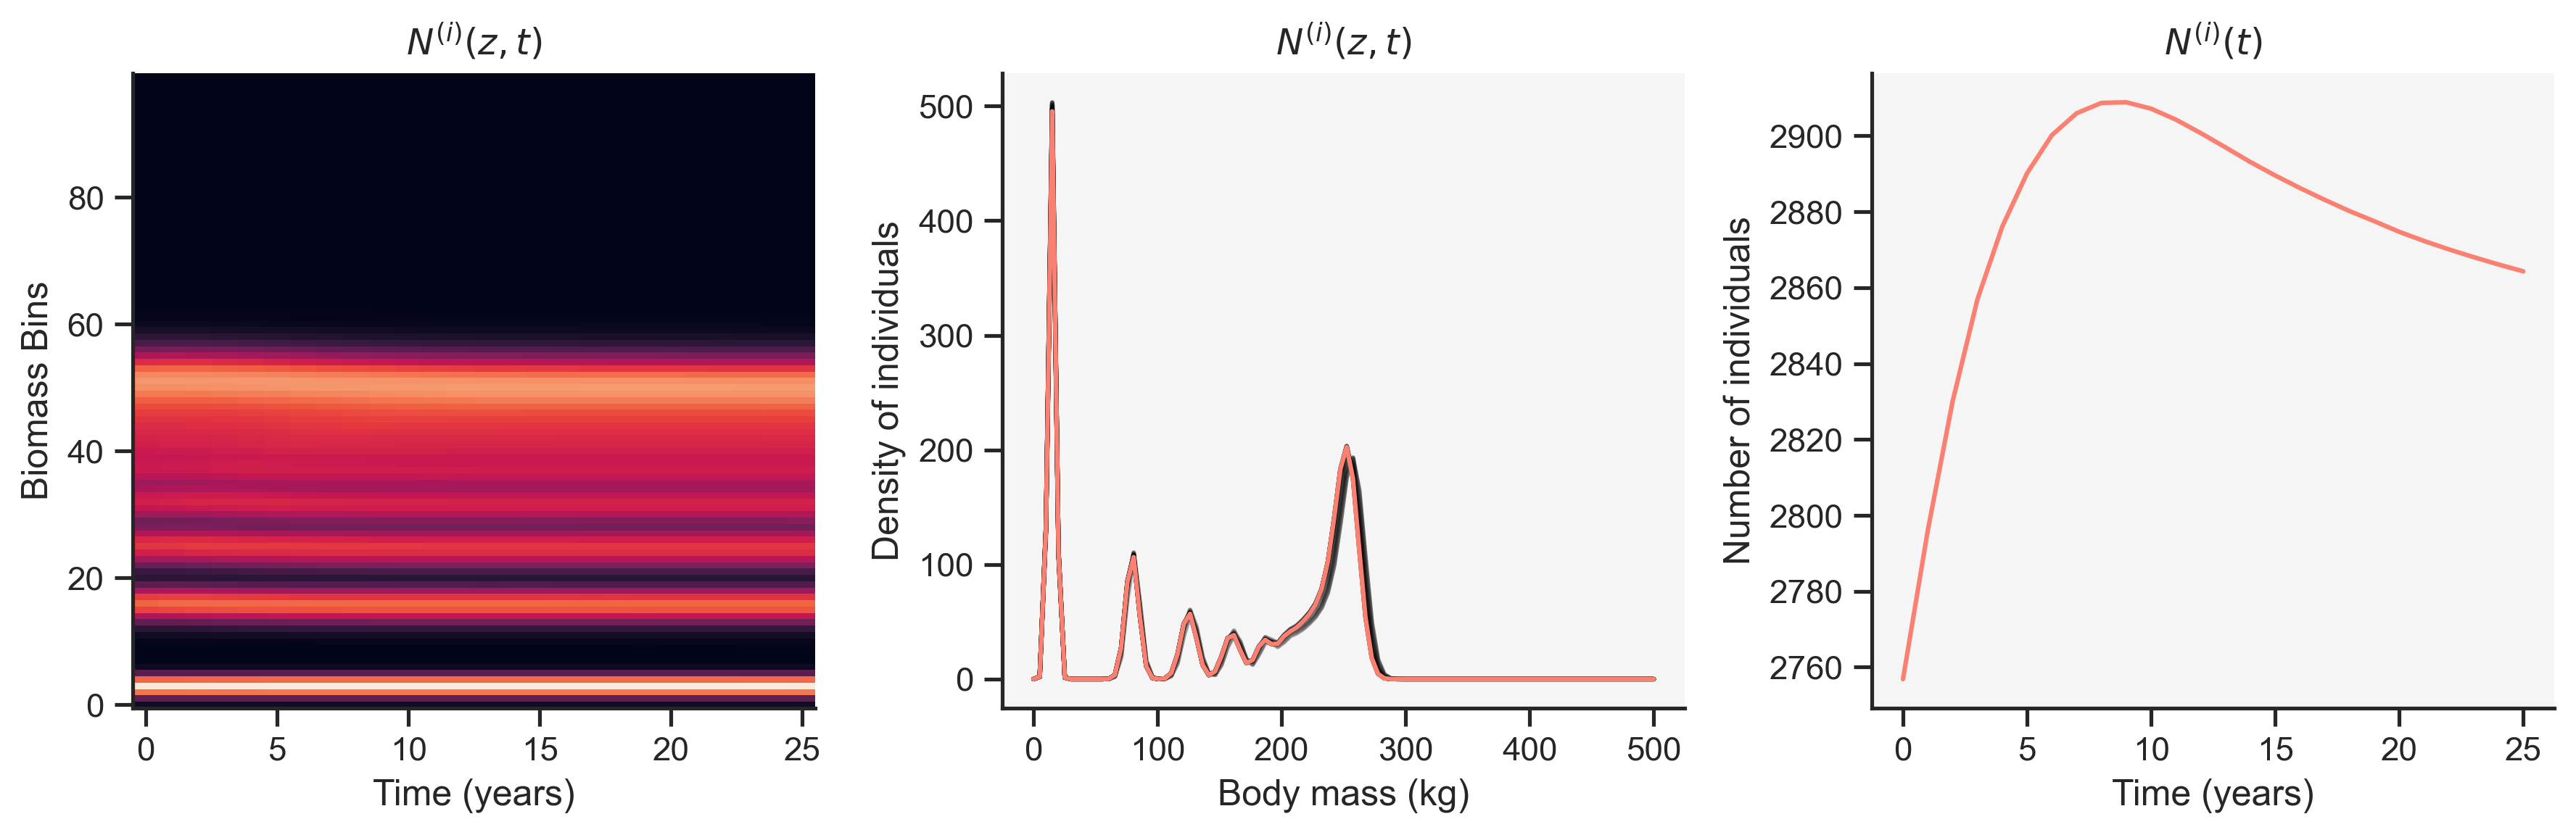

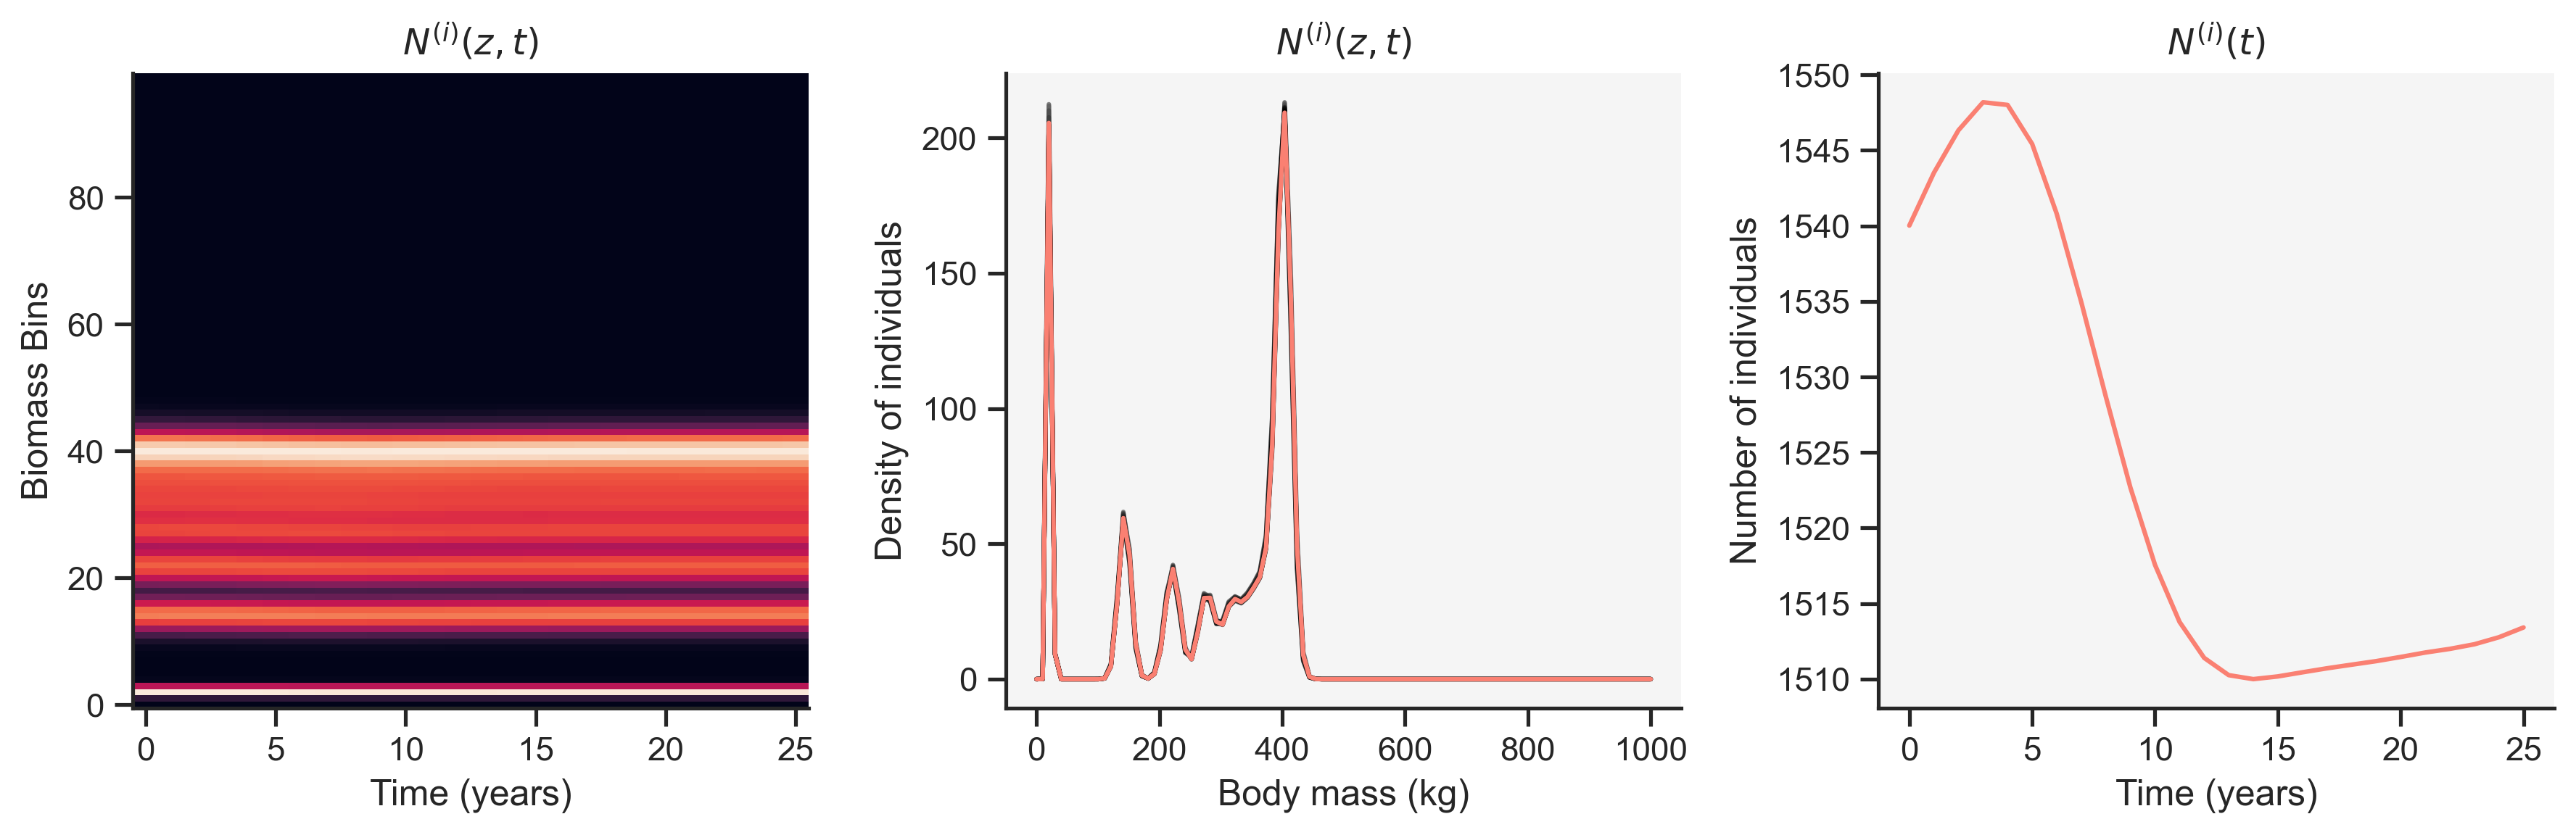

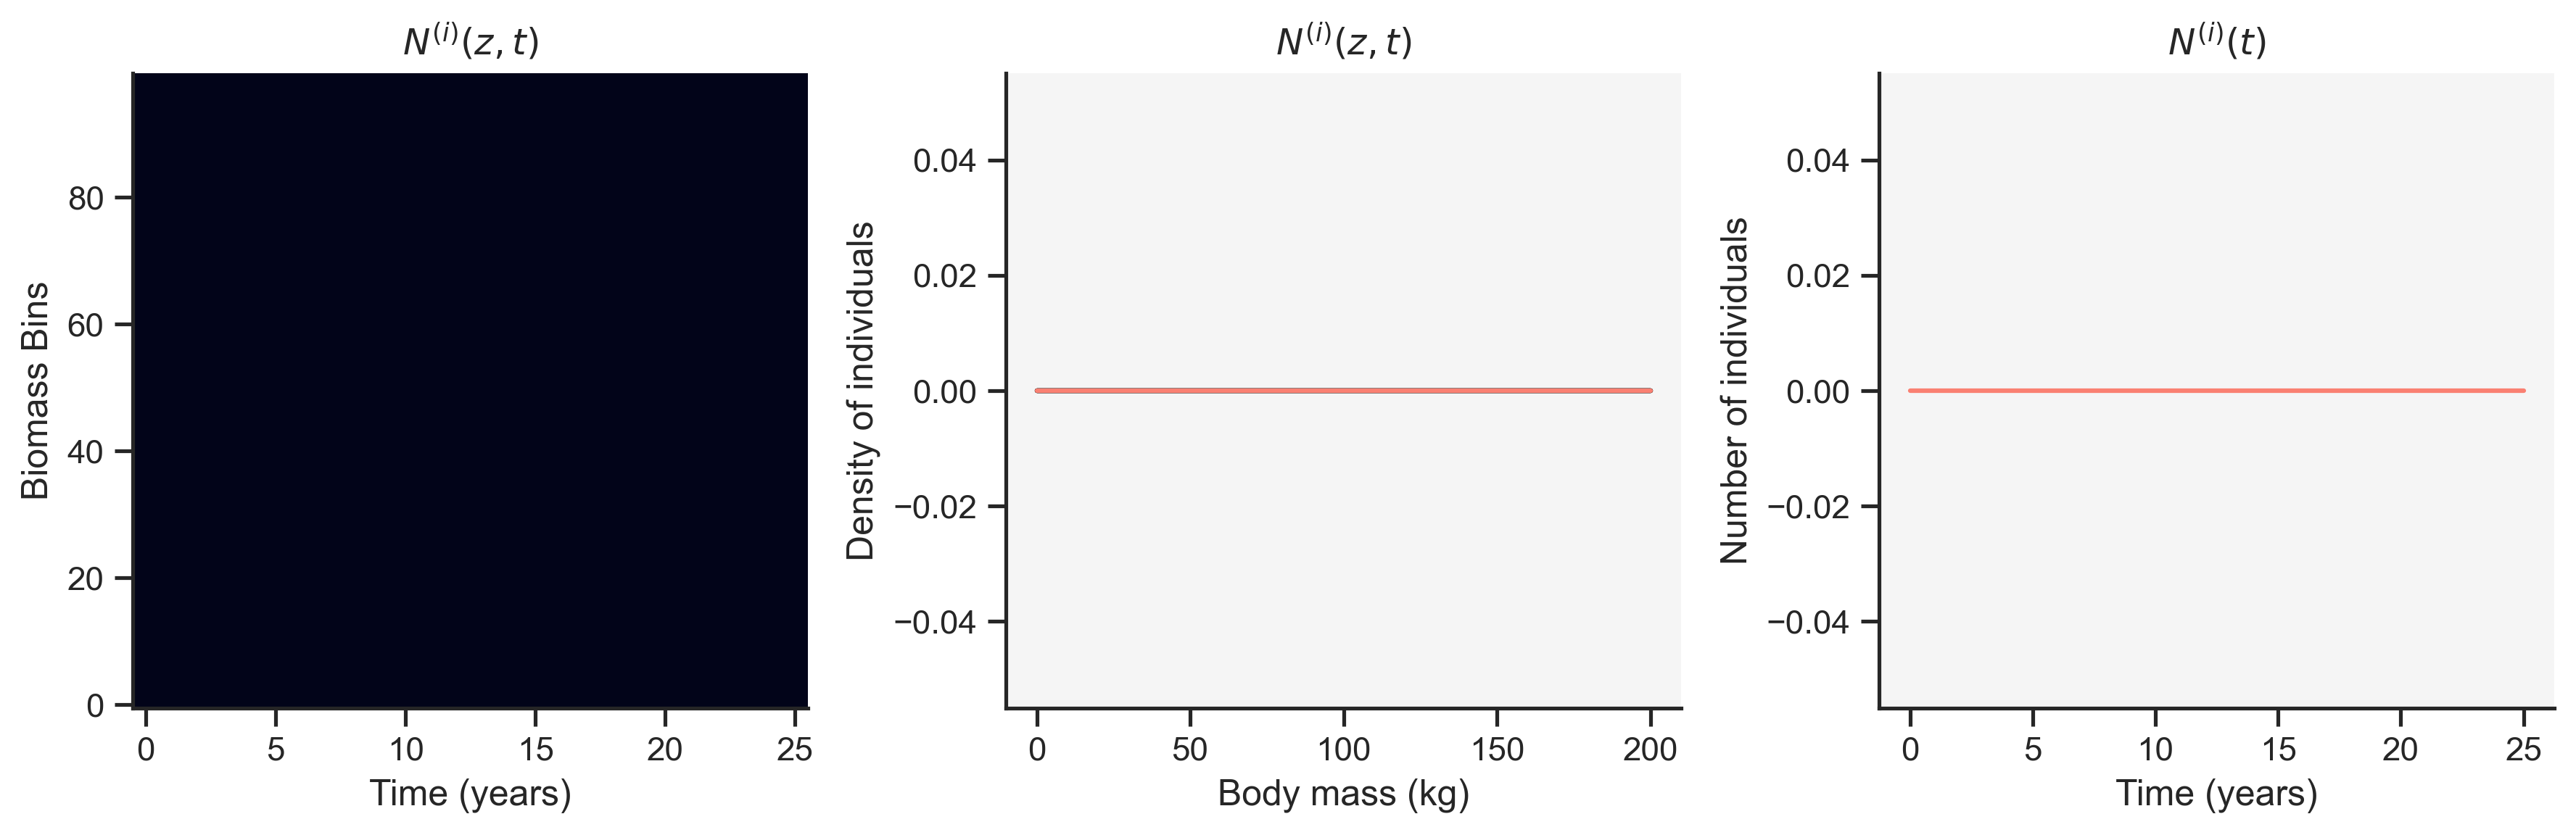

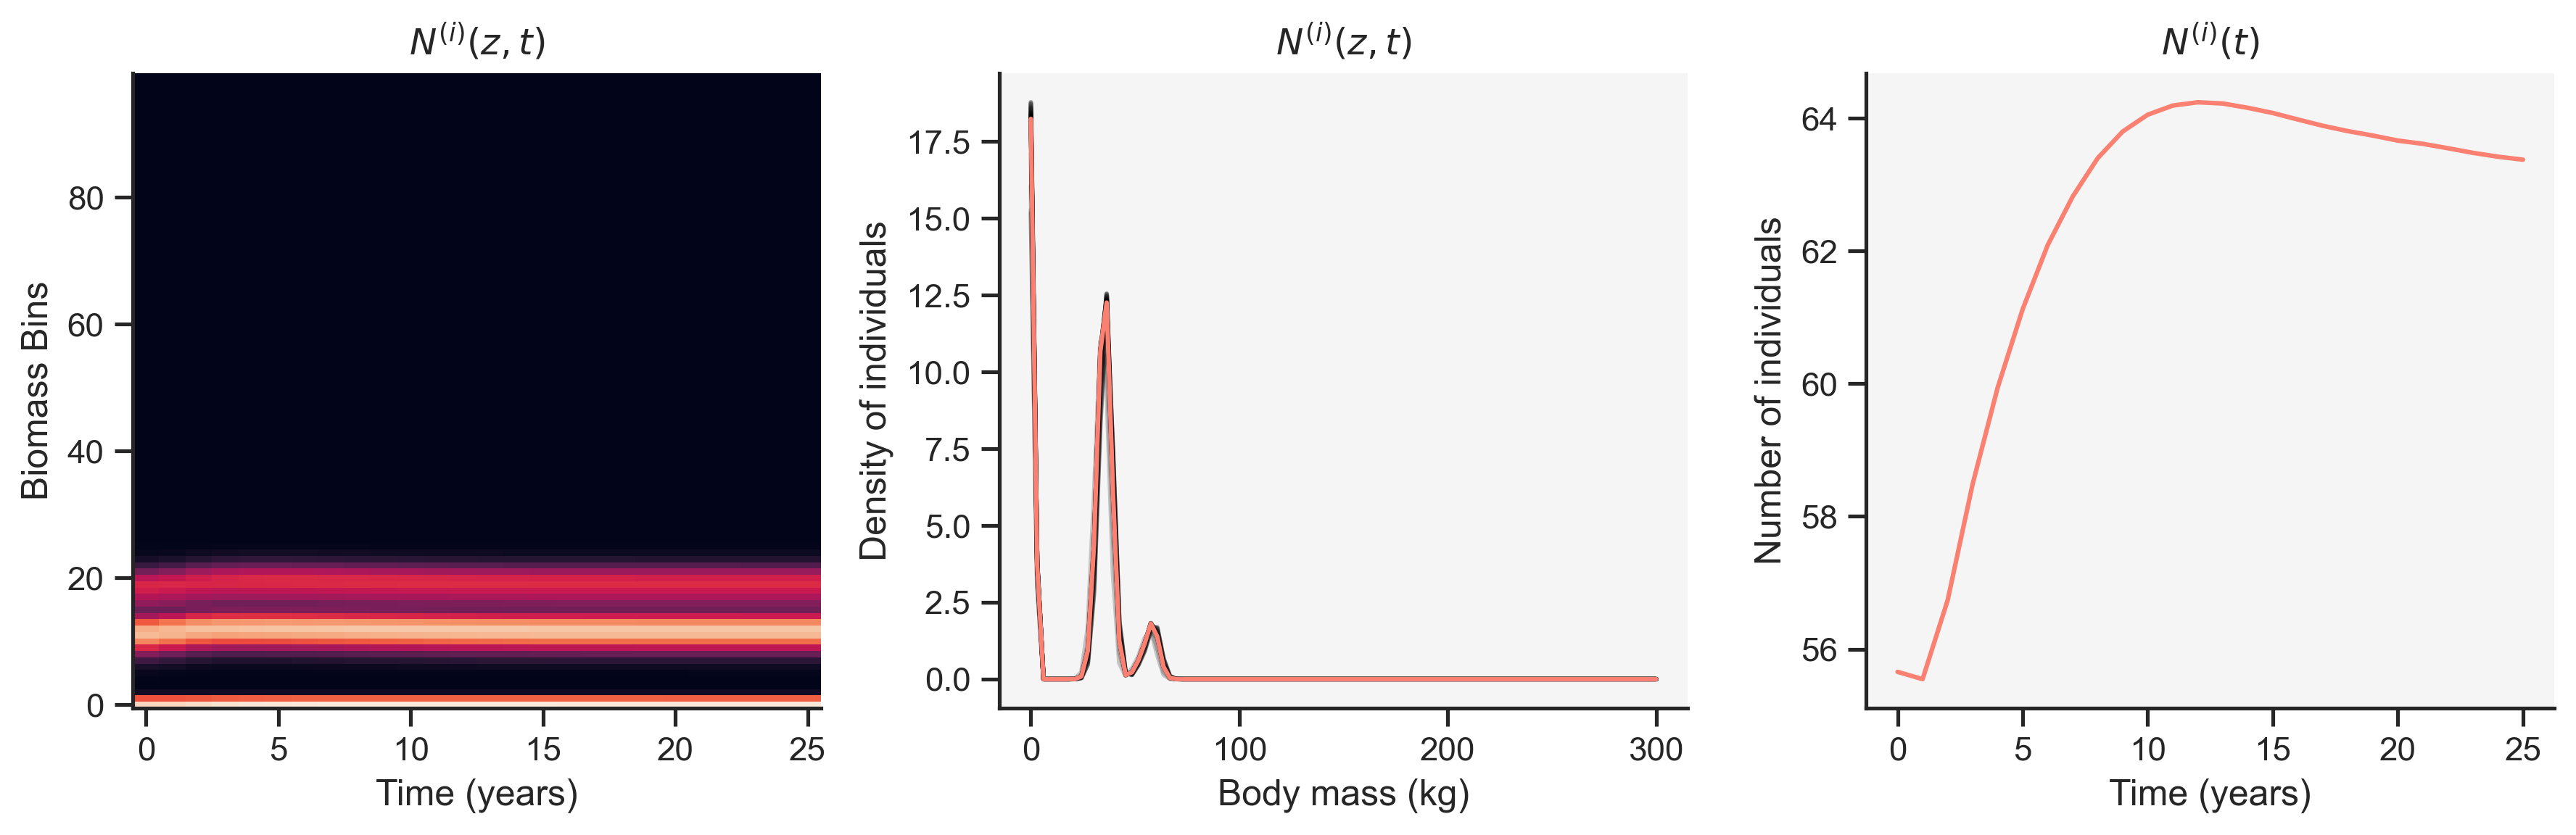

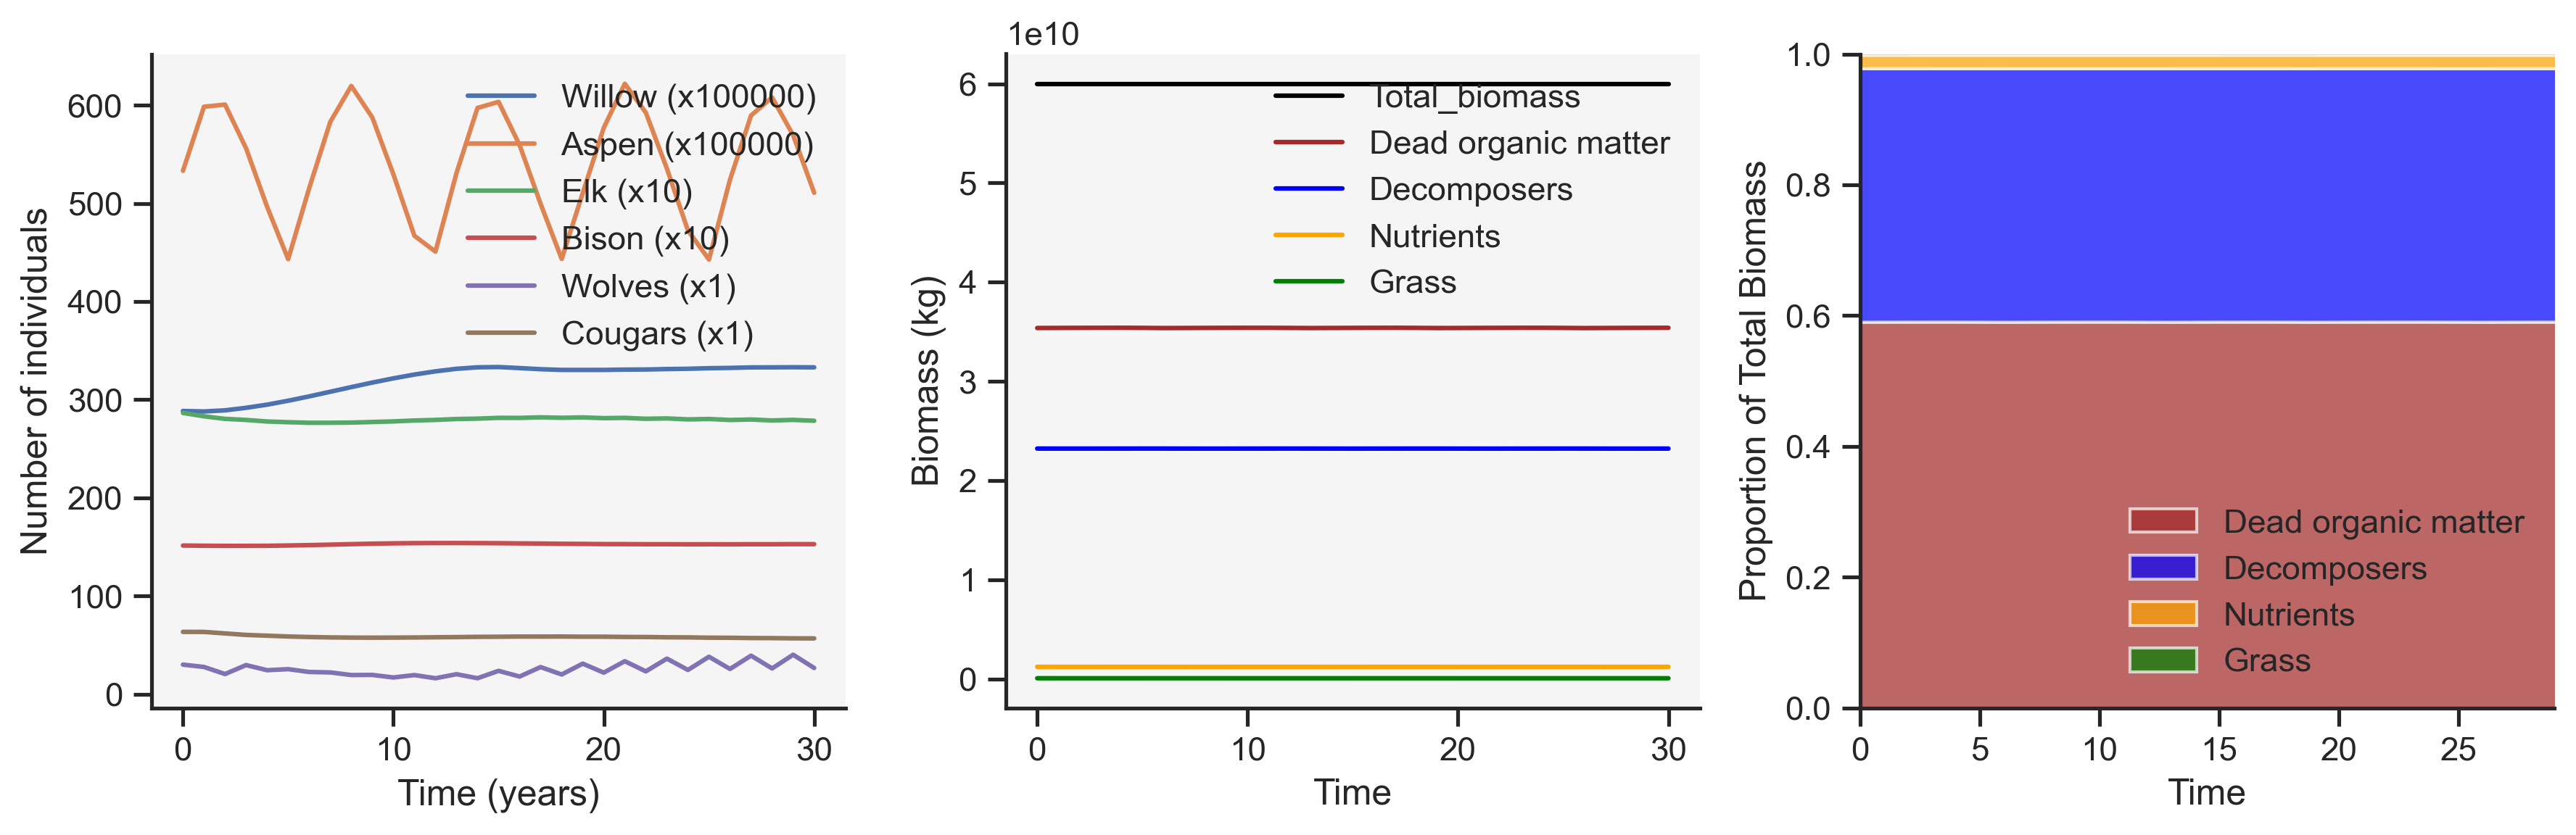

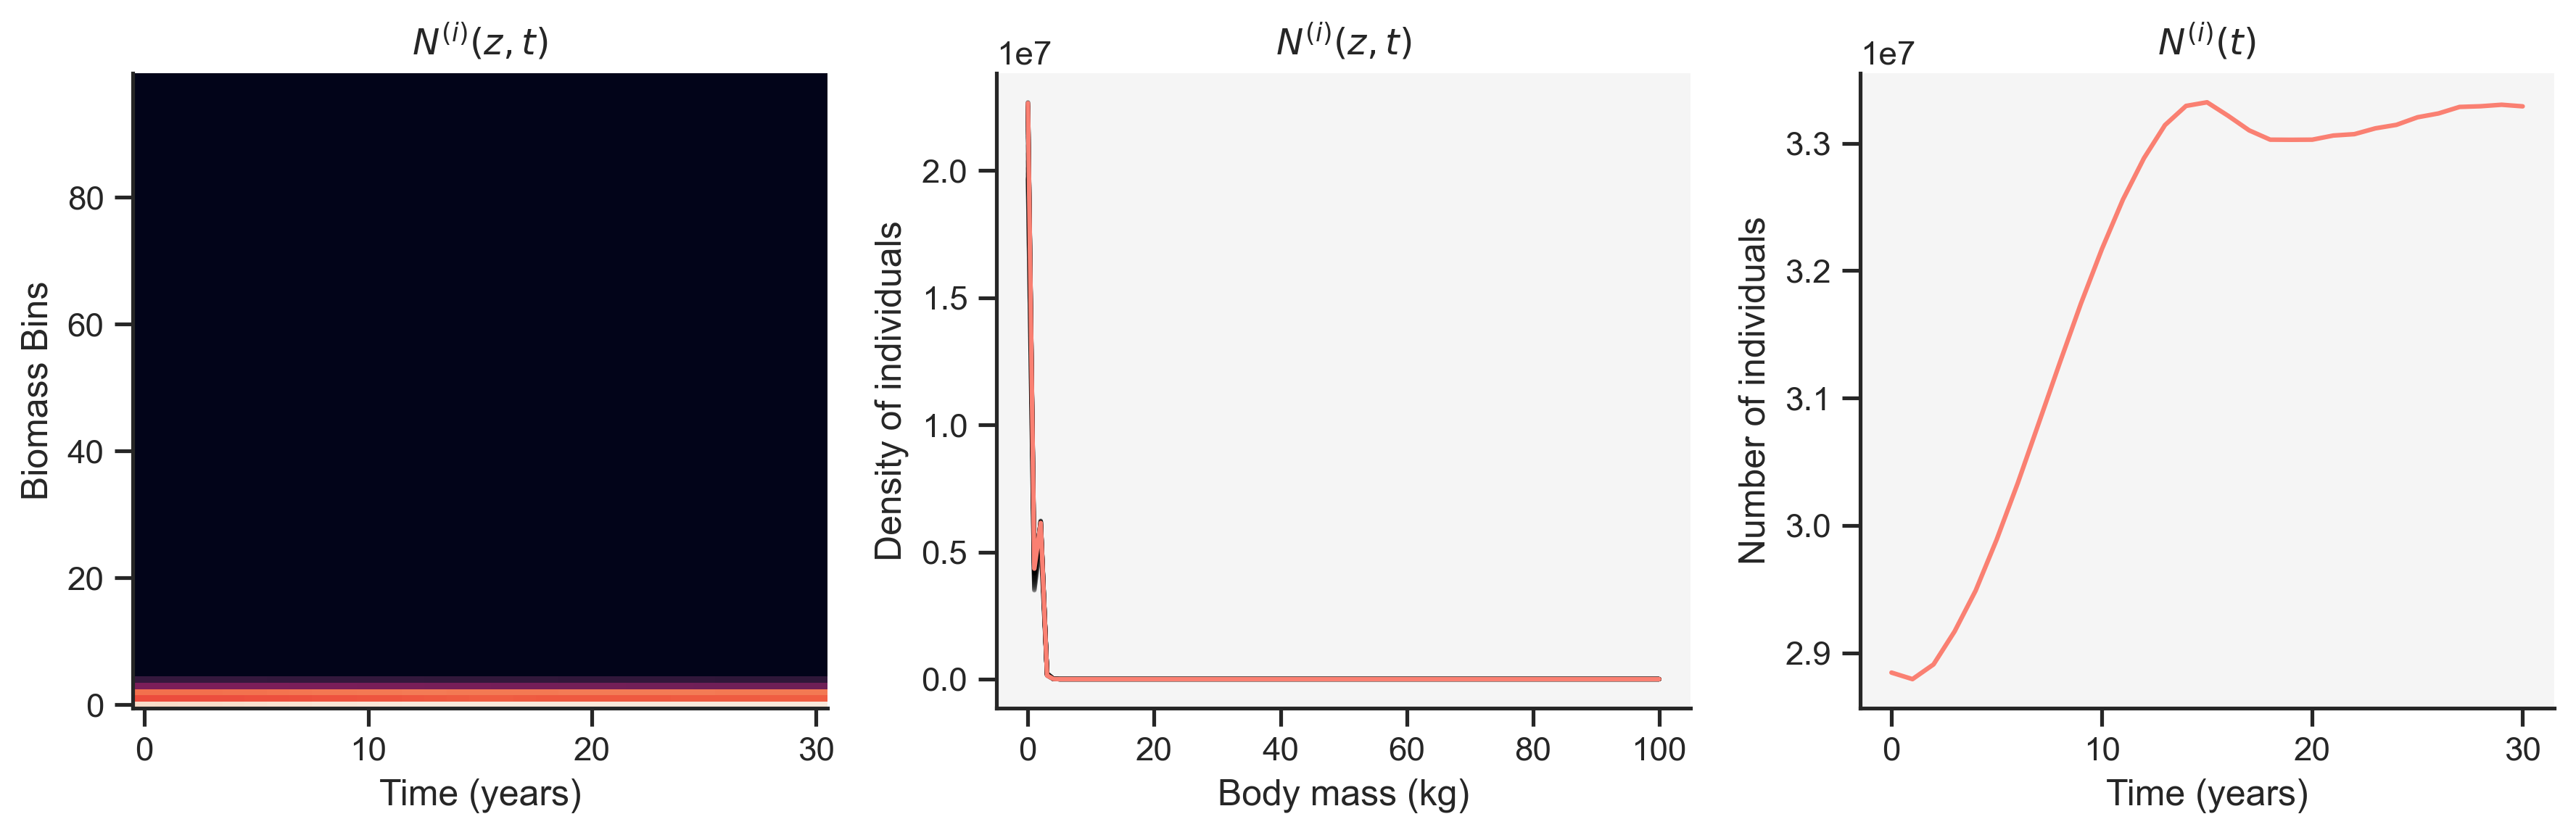

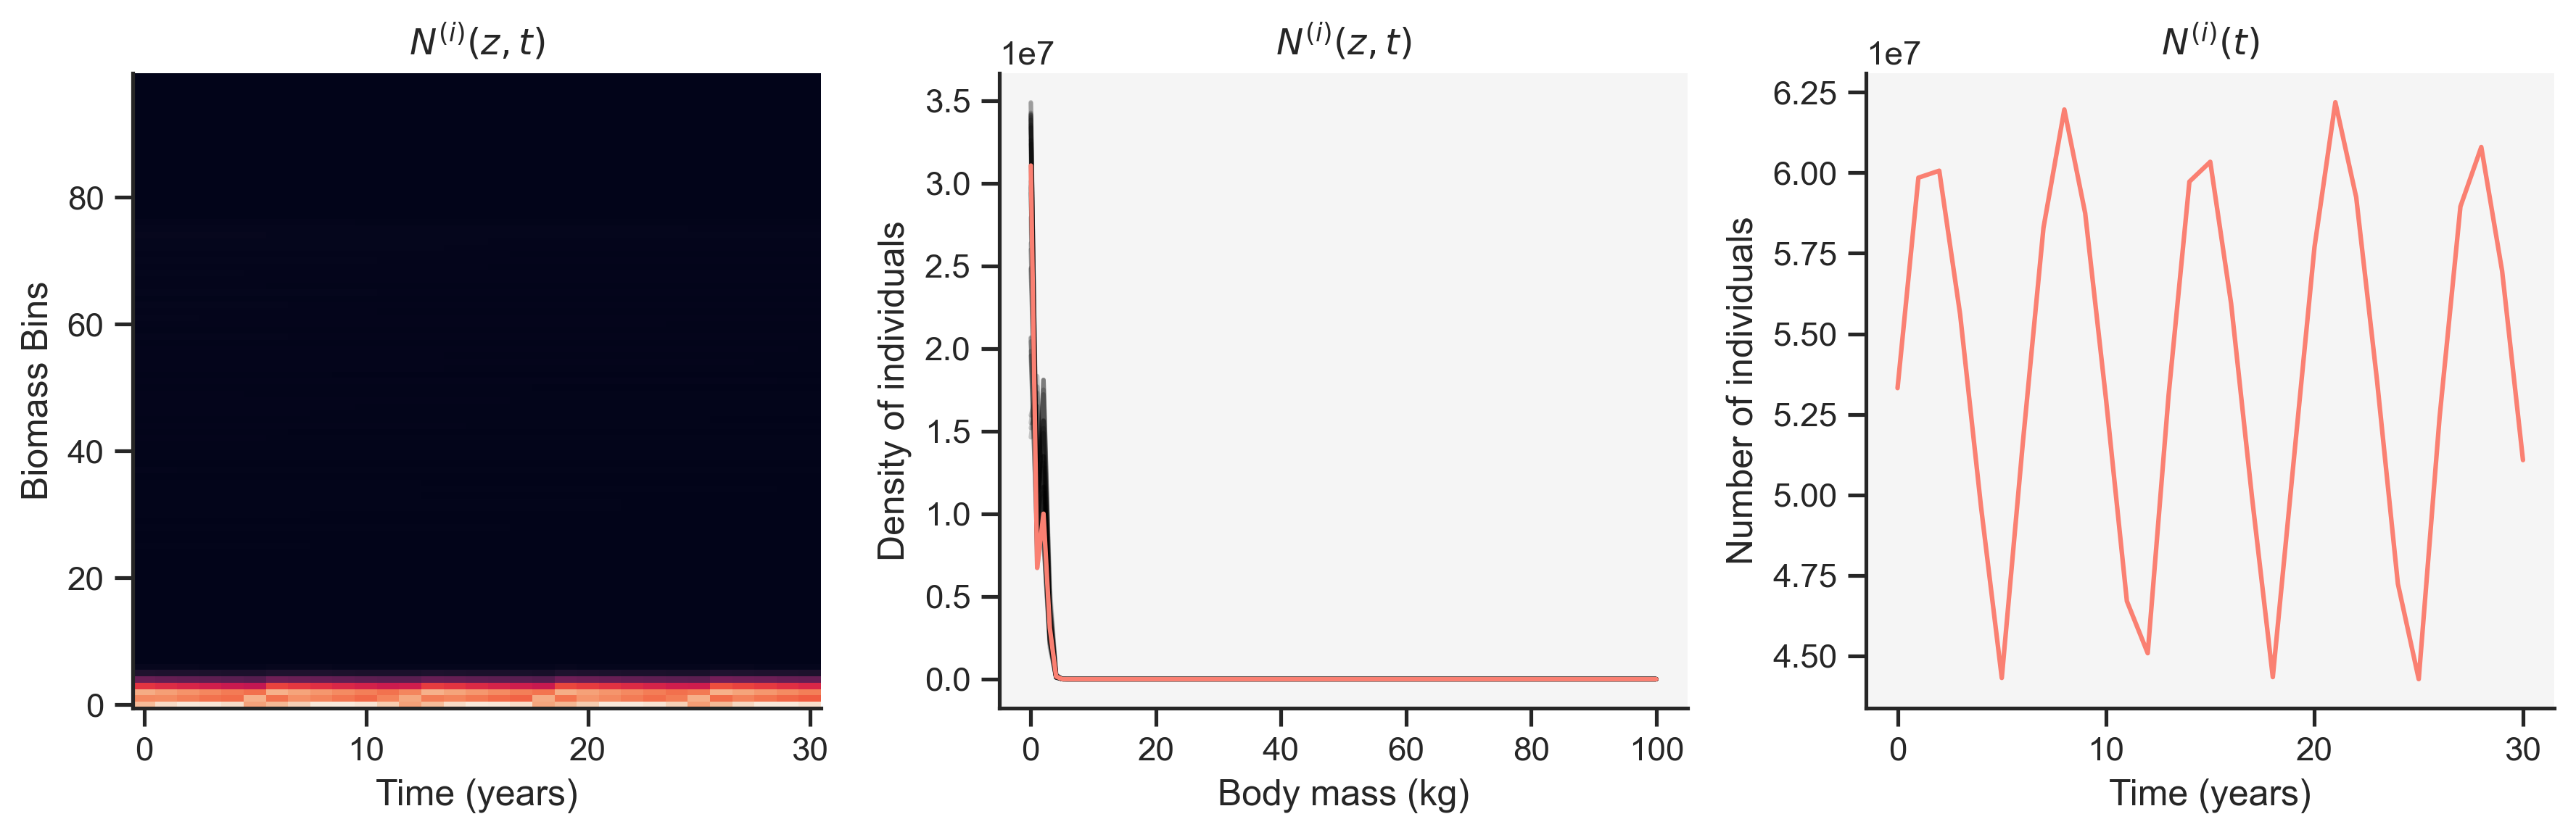

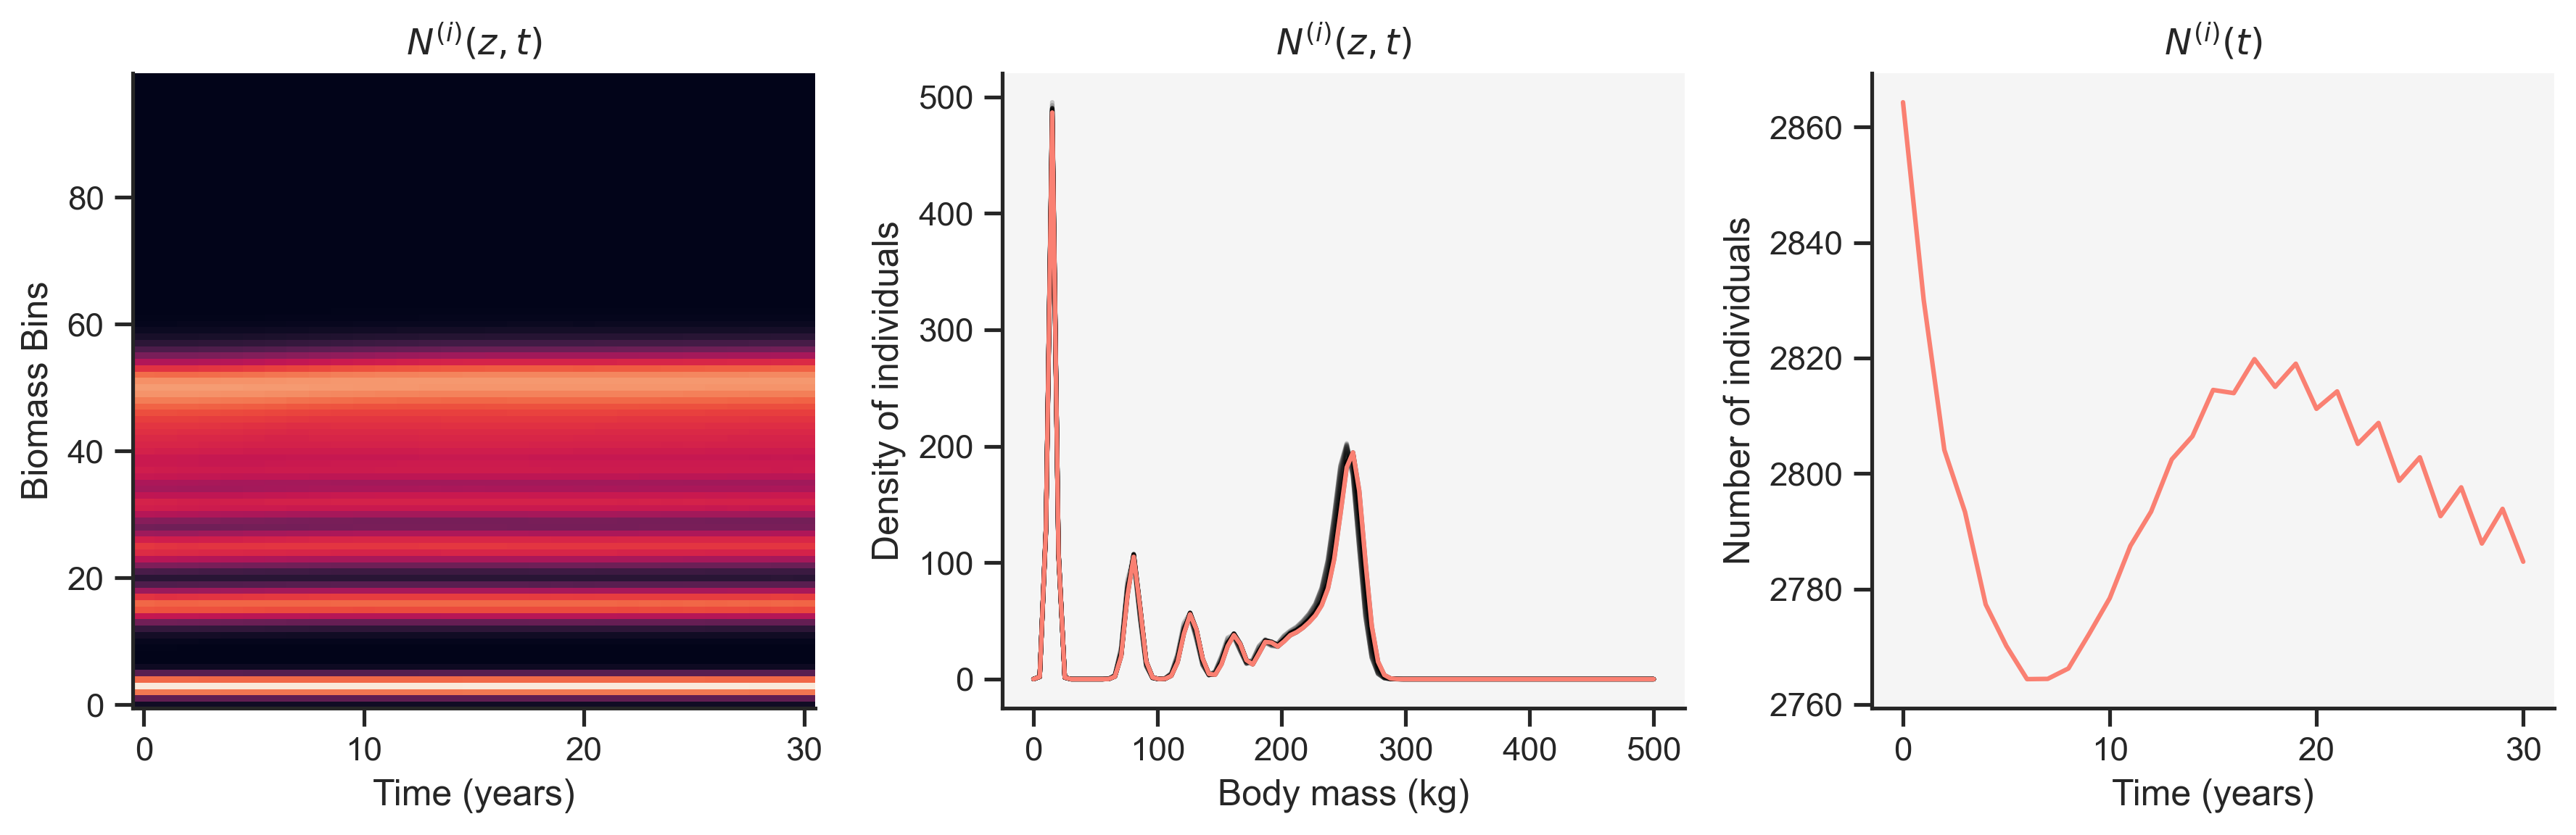

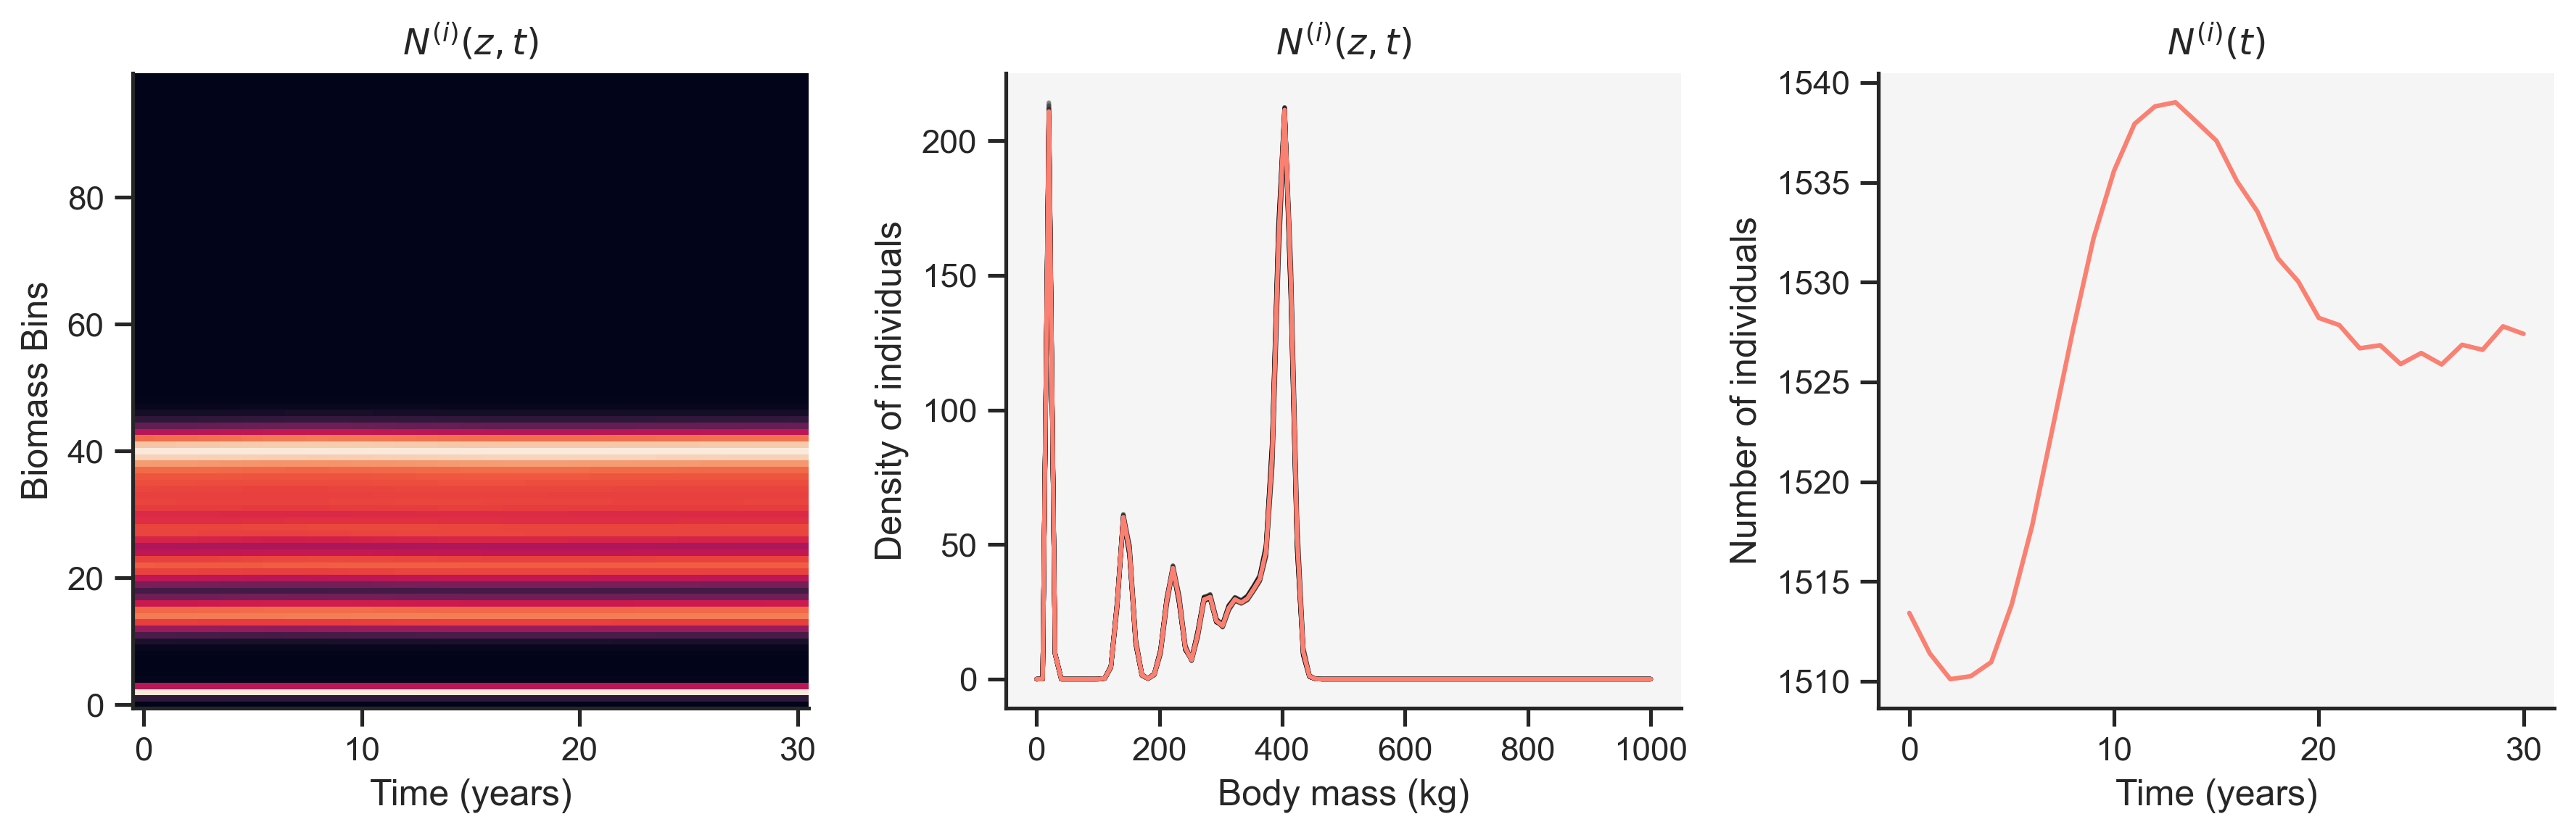

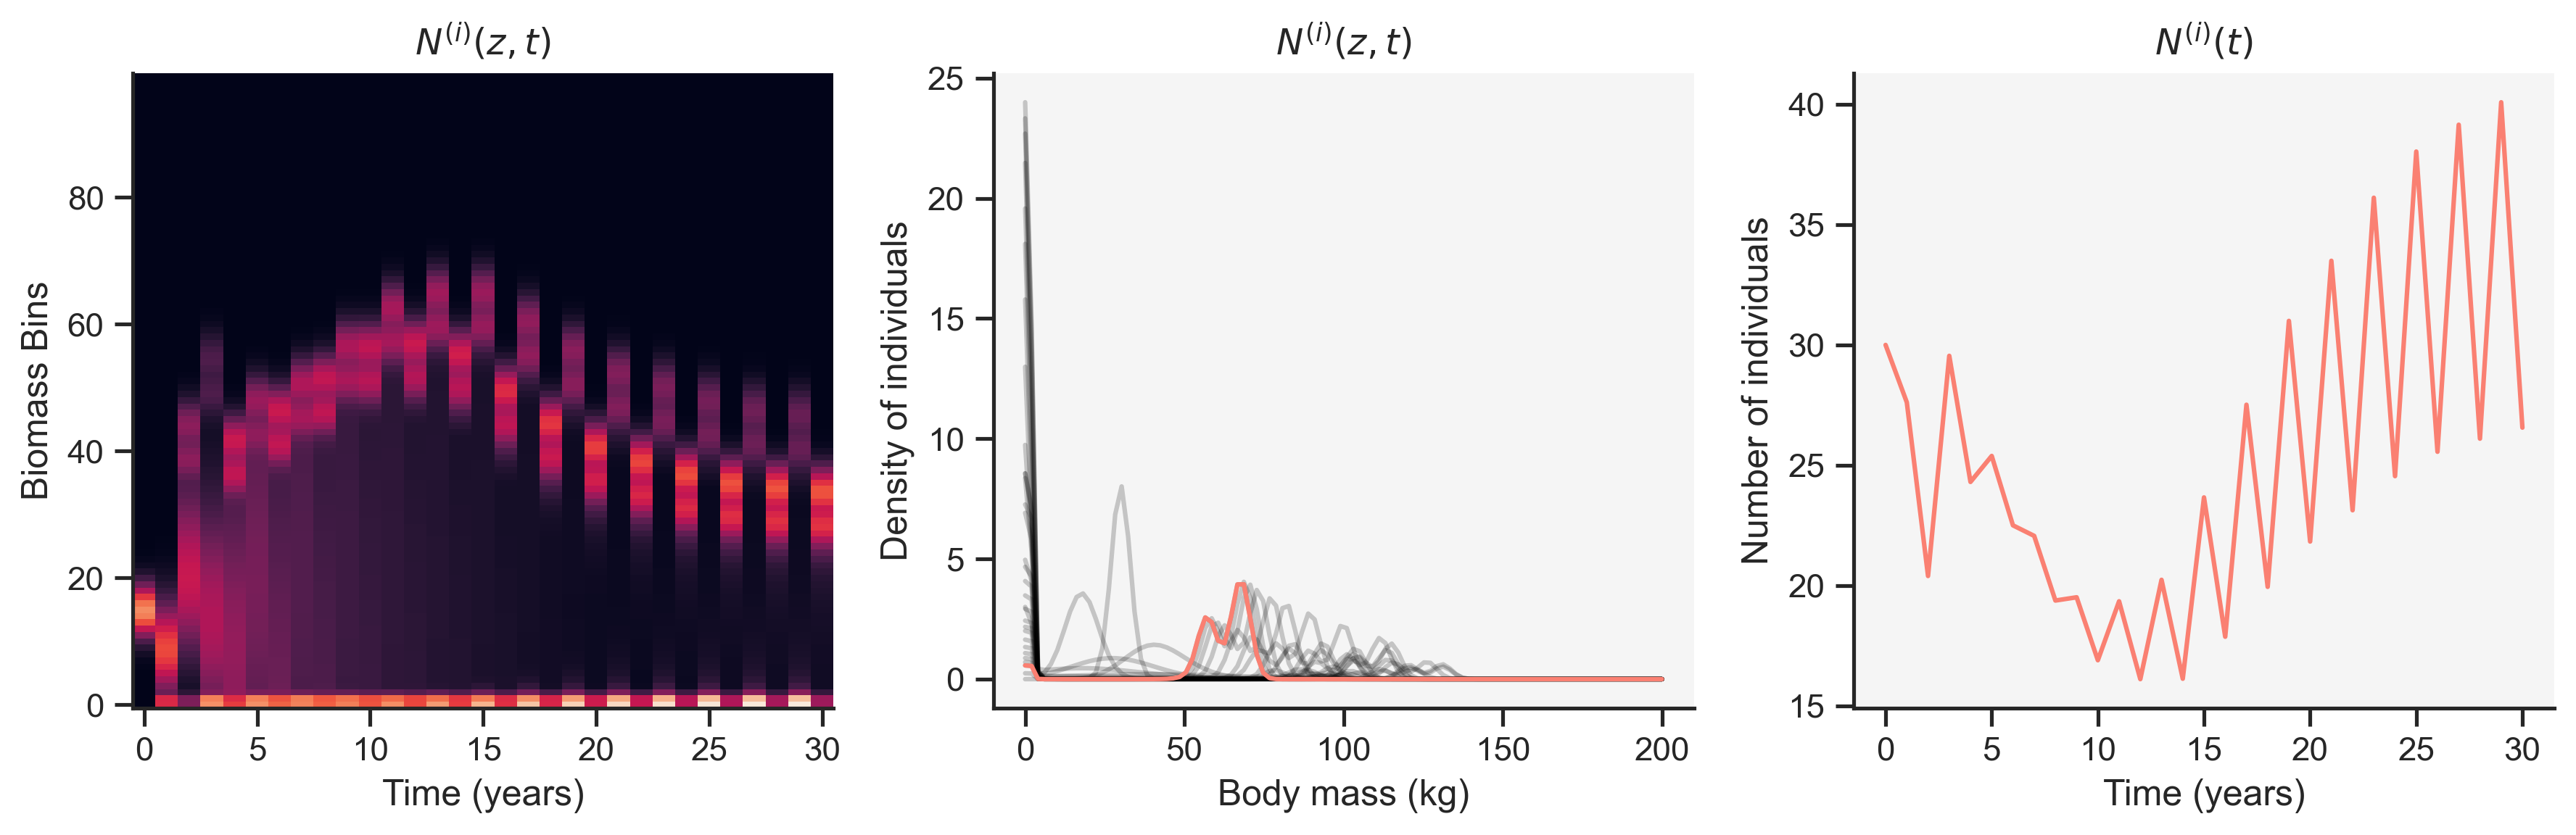

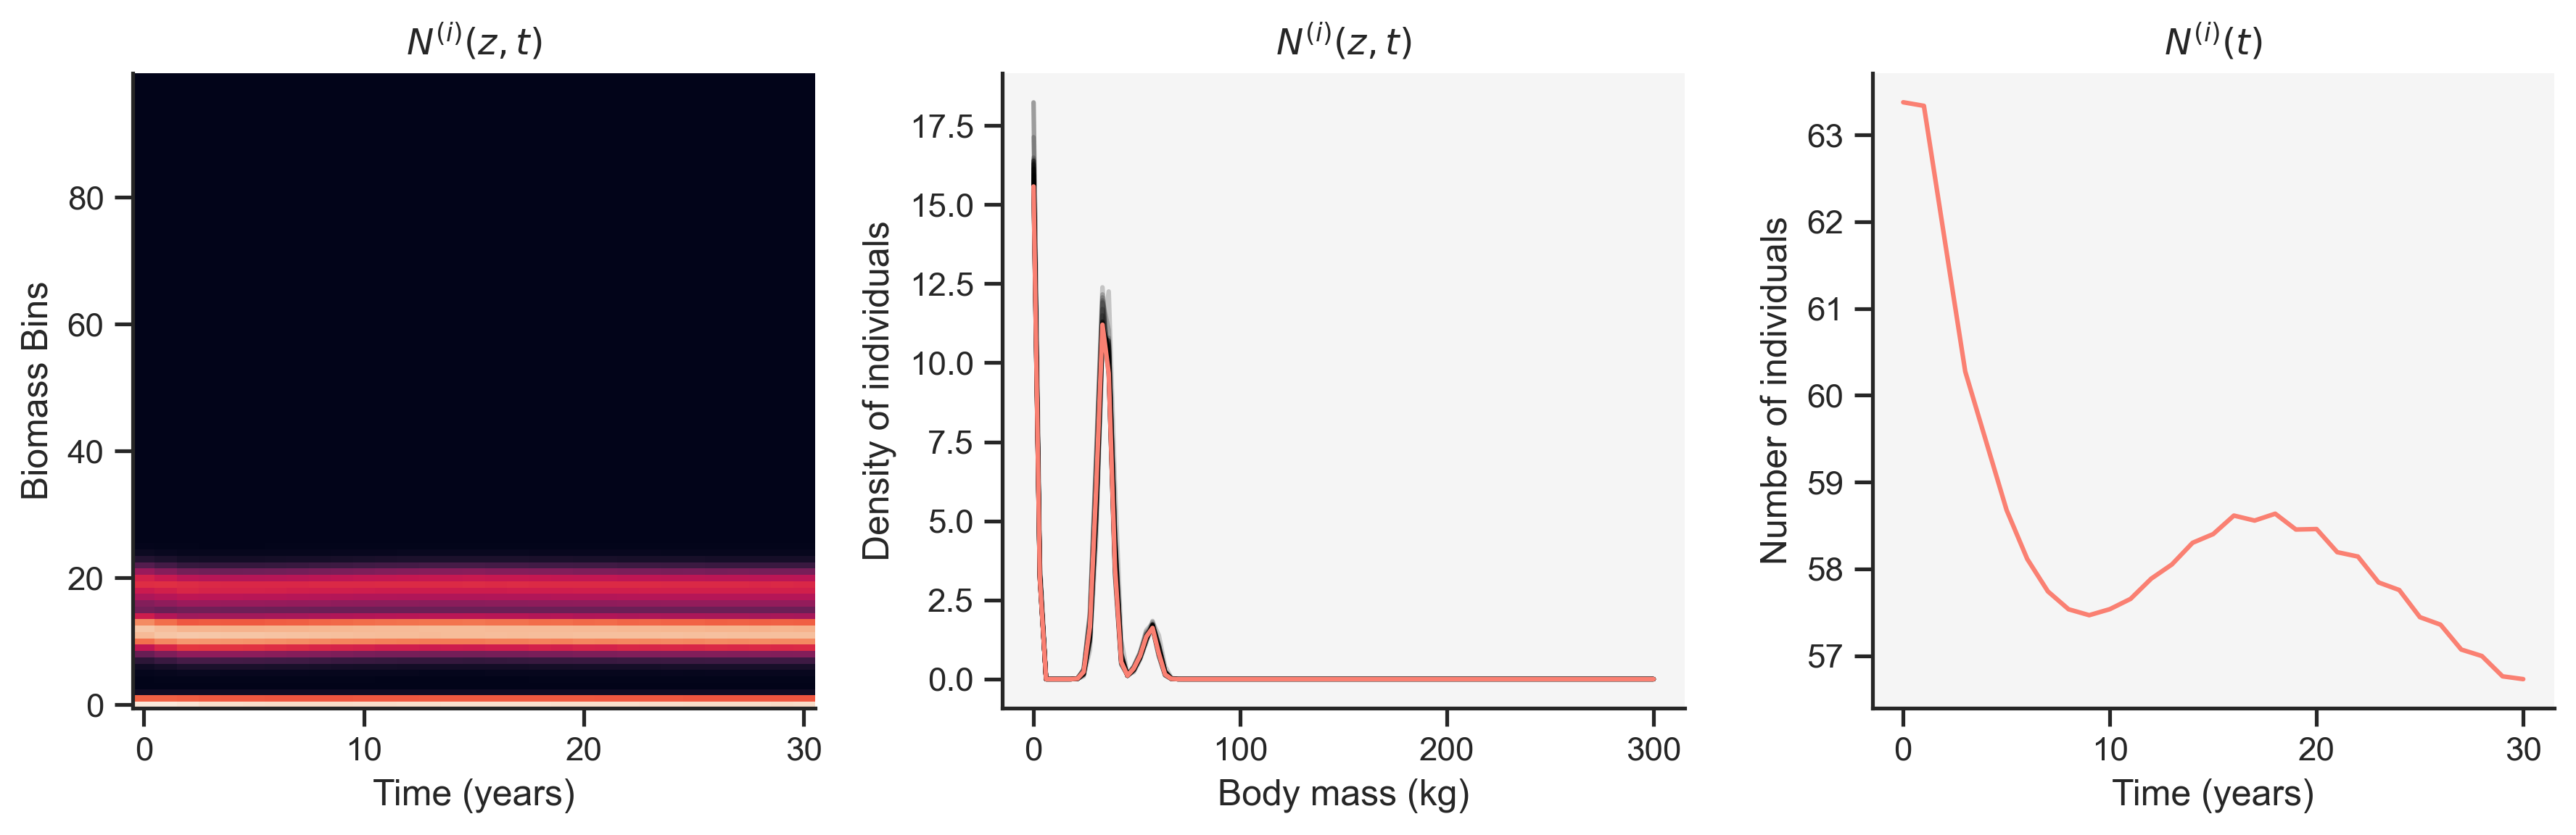

In [37]:
###################
## VISUALISATION ##
###################

TS = torch.cat((predictions_1[6],predictions_2[6],predictions_3[6]), dim=0)
plt.plot(TS)
plt.xlabel('Time (years)')
plt.ylabel('Count')
plt.yscale('log')

## Visualise
plot_model(predictions_1)
plot_model(predictions_2)
plot_model(predictions_3)

#
###